In [1]:
import pandas as pd
import numpy as np
from scipy import linalg
import sys
sys.path.append("/Users/coffee/Documents/code/QkidsAutomation")
import os
from qkids import Week
# from qkids.DatabasePool import get_schedule_connection
from schedule.GBDT import prepare_data
import matplotlib.pyplot as plt
from qkids.DatabasePool import get_odps
odps = get_odps()

In [3]:
week = Week()
historical_data = prepare_data()
historical_data['year'] = historical_data.begin.apply(lambda x: x.year)
historical_data['time_index'] = historical_data.time.apply(lambda x: week.day_times.index(x))

In [80]:
students = odps.get_table('dwd_students').to_df()
students = students[students.registed_at.notnull()]
students['date'] = students.registed_at.strftime("%Y-%m-%d")

In [83]:
student_cnt_by_date = students.groupby('date').agg(count=students.date.count())

In [84]:
student_cnt_by_date = student_cnt_by_date.to_pandas()

TransientProgressBar(value=0.0)

InstancesProgress()

HTMLNotifier()

In [87]:
student_cnt_by_date = student_cnt_by_date.set_index('date')
student_cnt_by_date = student_cnt_by_date['count']

In [97]:
student_cnt_by_date_cumsum = student_cnt_by_date.cumsum()

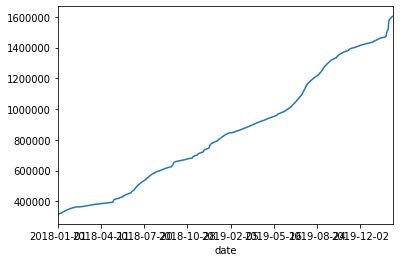

In [99]:
student_cnt_by_date_cumsum.loc['2018-01-01':].plot()

# 查看数据

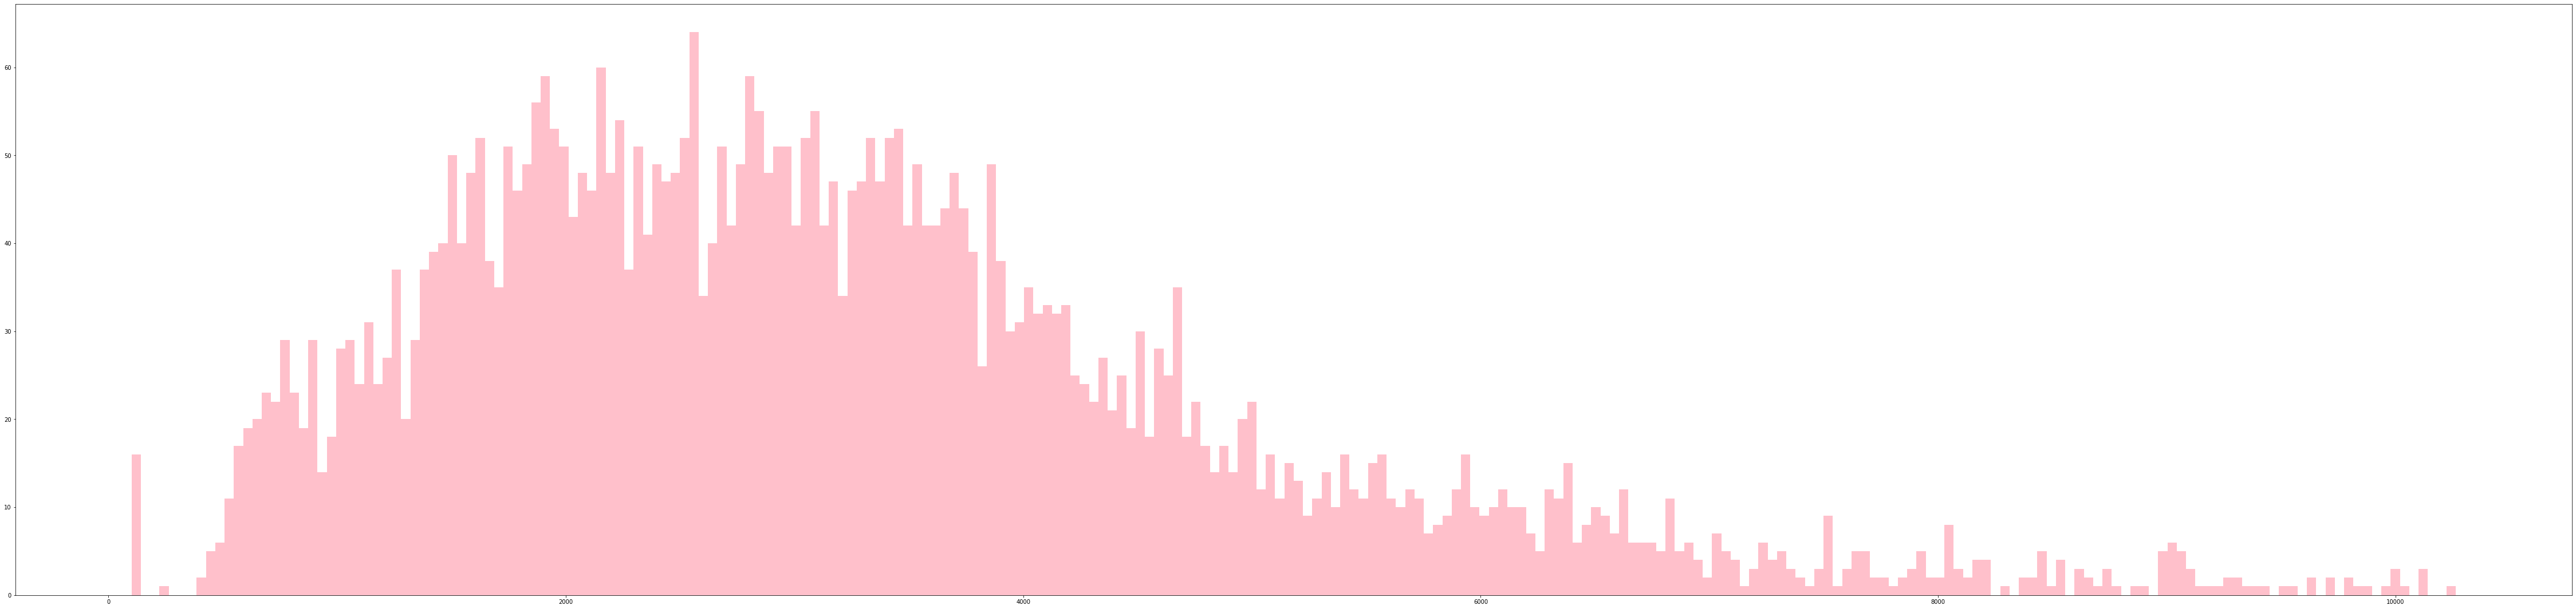

In [17]:
fig = plt.figure(0,figsize=(80, 19))
ax = fig.add_subplot(1,1,1)
ax.hist(historical_data.cnt.values, bins=250, color='pink', density=False)
plt.show()

In [20]:
historical_data_chapter = historical_data[['begin','cnt']].groupby('begin').sum().reset_index()
historical_data_chapter['time'] = historical_data_chapter.begin.apply(lambda x:x.time())
historical_data_chapter['date'] = historical_data_chapter.begin.apply(lambda x:x.strftime("%Y-%m-%d"))
historical_data_chapter['time_index'] = historical_data_chapter.time.apply(lambda x: week.day_times.index(x))
historical_data_chapter['dayofweek'] = historical_data_chapter.begin.apply(lambda x:x.dayofweek)
historical_data_chapter['weekofyear'] = historical_data_chapter.begin.apply(lambda x:x.weekofyear)

### 查看不同时间点的数据情况

In [21]:
historical_data_chapter[['time','cnt']].groupby(['time']).describe()

cnt                                                              \
          count         mean          std     min      25%     50%      75%   
time                                                                          
07:50:00    6.0  1533.500000   763.782888   257.0  1158.00  1835.5  2065.25   
08:30:00  350.0  2343.411429  1026.287242   408.0  1551.25  2252.0  3261.25   
09:10:00  357.0  2502.403361  1174.706894   101.0  1566.00  2368.0  3583.00   
09:50:00  358.0  2433.106145  1137.044414   102.0  1570.50  2290.5  3478.50   
10:30:00  350.0  2097.640000   940.679055   465.0  1341.50  2005.5  2902.50   
11:10:00  350.0  1649.734286   678.641244   472.0  1148.00  1645.5  2101.00   
11:50:00    6.0  2074.166667   164.171151  1766.0  2056.50  2132.0  2144.50   
13:30:00    6.0   702.000000    74.102632   589.0   654.75   726.5   753.25   
14:10:00    6.0   657.333333    70.661635   550.0   612.50   679.0   711.75   
14:50:00    6.0   576.000000    70.815253   490.0   530.25   576.0   600.00   
15:30:00    6.0   567.166667    77.383245   438.0   543.00   572.0   612.25   
16:10:00    6.0   512.500000    68.797529   402.0   491.75   510.5   550.25   
17:50:00   10.0  1509.400000   370.866014   788.0  1384.25  1536.0  1764.50   
18:30:00  748.0  3119.974599  1463.287387   685.0  2037.50  2821.0  3853.00   
19:10:00  749.0  3995.048064  1731.767957  1073.0  2685.00  3700.0  4975.00   
19:50:00  748.0  4469.564171  1819.537700  1217.0  3154.25  4139.5  5432.25   
20:30:00  747.0  3947.077644  1755.177891   120.0  2726.00  3522.0  4925.50   

                   
              max  
time               
07:50:00   2199.0  
08:30:00   5095.0  
09:10:00   5474.0  
09:50:00   5371.0  
10:30:00   5126.0  
11:10:00   4190.0  
11:50:00   2235.0  
13:30:00    777.0  
14:10:00    723.0  
14:50:00    691.0  
15:30:00    662.0  
16:10:00    603.0  
17:50:00   1955.0  
18:30:00   8448.0  
19:10:00  10114.0  
19:50:00  10263.0  
20:30:00   9375.0

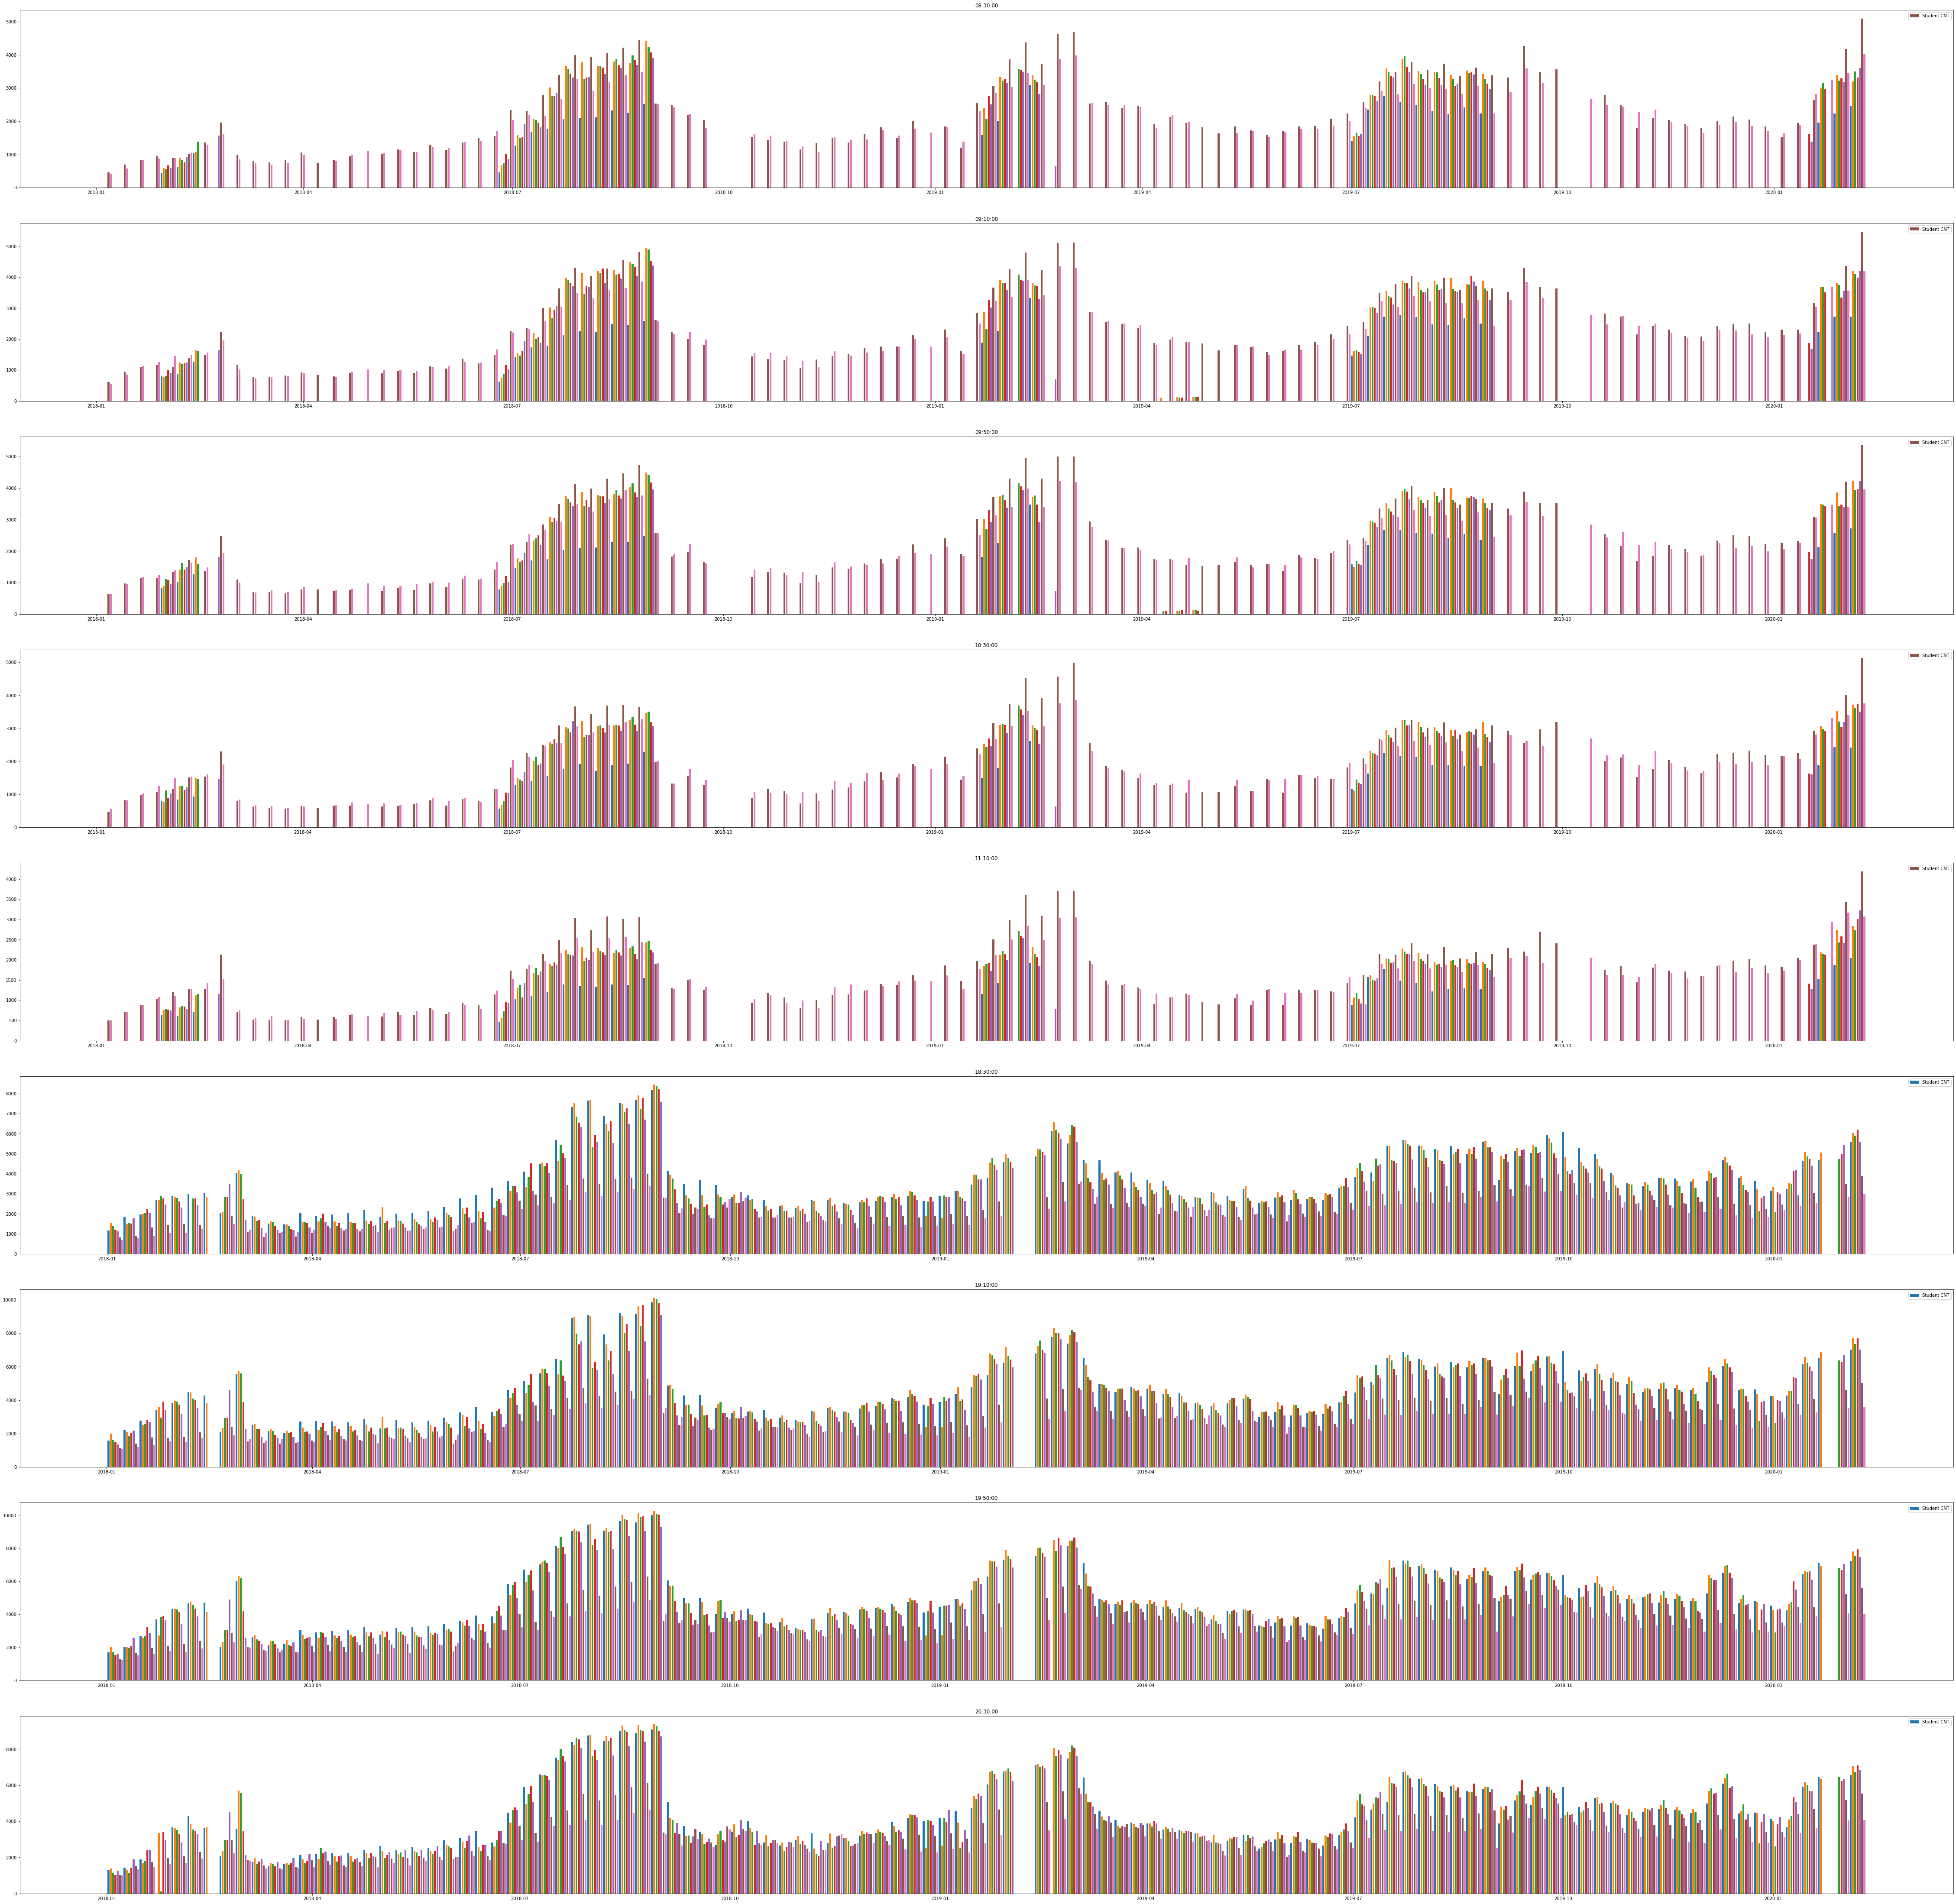

In [58]:
# 设置颜色
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = [i['color'] for i in prop_cycle ]
historical_data_chapter['color'] = historical_data_chapter.dayofweek.apply(lambda x:colors[x] )

fig_index = 1
fig = plt.figure(0,figsize=(80, 80))
for time, data_by_time in historical_data_chapter.groupby('time'):
    if len(data_by_time) < 50 :
        continue
    ax = fig.add_subplot(9,1,fig_index)
    ax.bar(data_by_time.begin.values, data_by_time.cnt.values, color =data_by_time.color.values, label='Student CNT')
    ax.set_title(time.strftime('%H:%M:%S'))
    fig_index += 1
    ax.legend()
plt.show()

由图可得， 各时间点 概率同分布

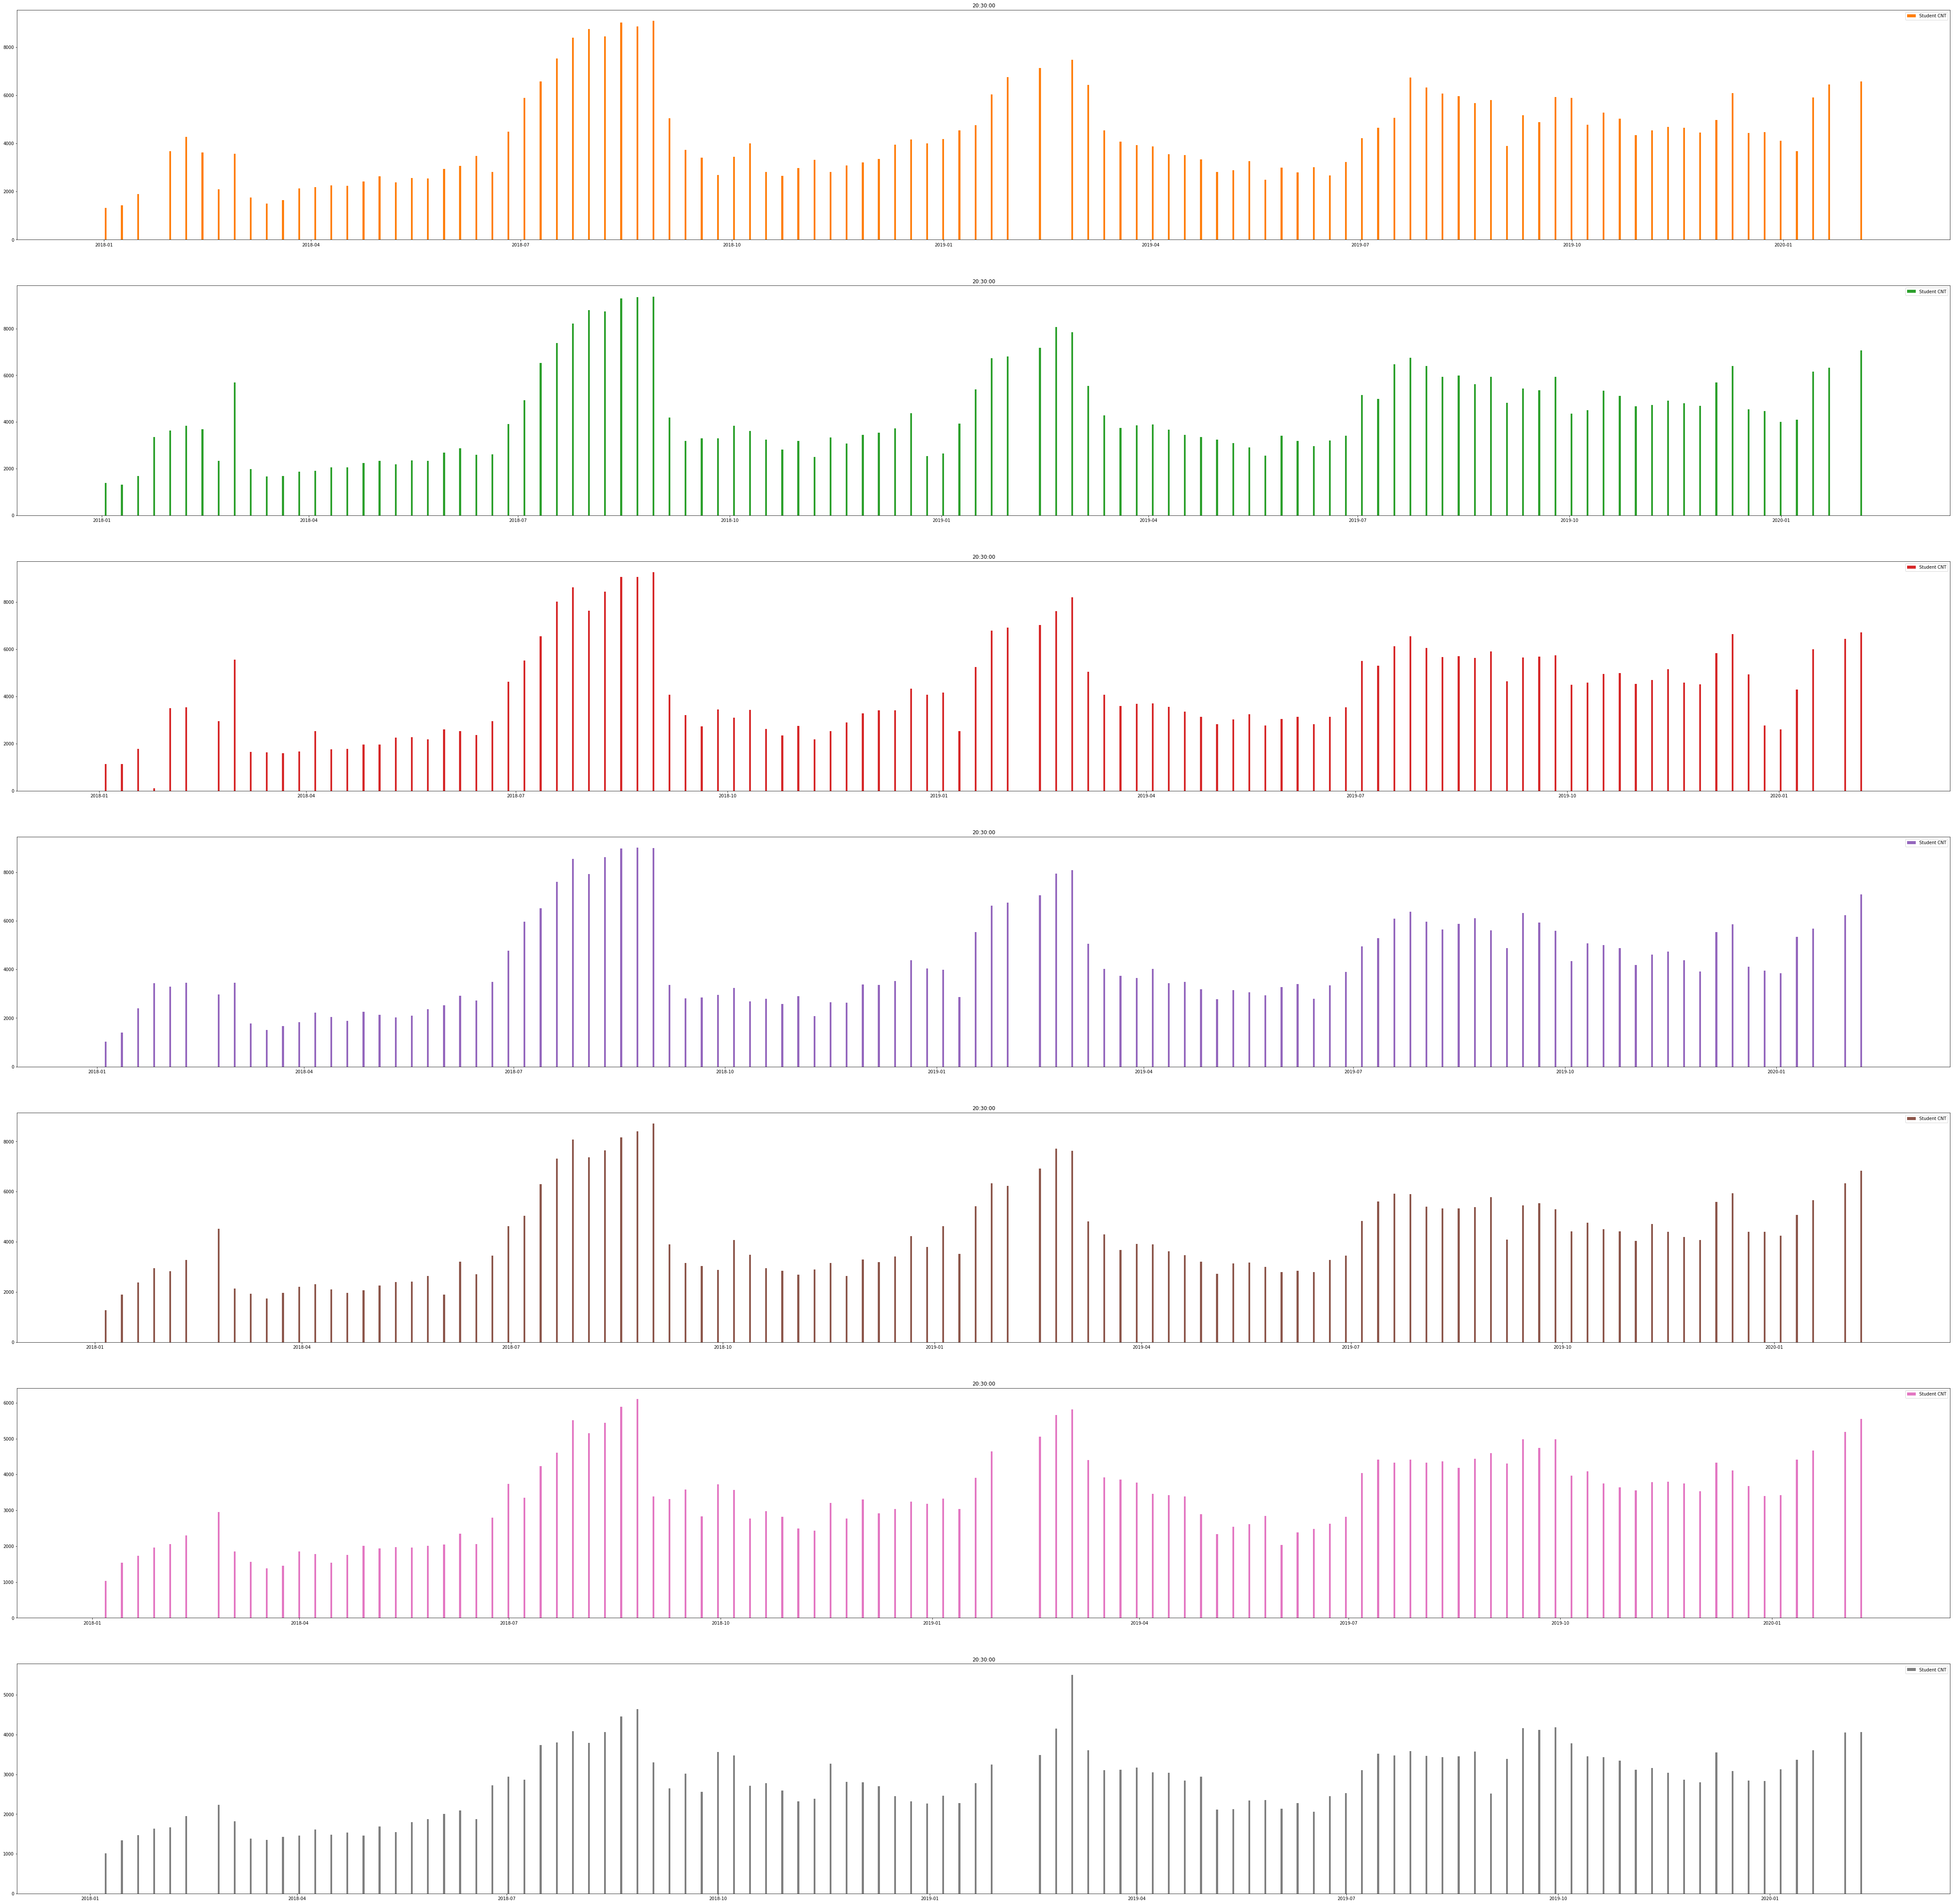

In [62]:
# 根据 day of year 查看数据
fig_index = 1
fig = plt.figure(1,figsize=(80, 80))
for weekofyear, data_by_dayofweek in data_by_time.groupby('dayofweek'):
    ax = fig.add_subplot(7,1,fig_index)
    ax.bar(data_by_dayofweek.begin.values, data_by_dayofweek.cnt.values, label='Student CNT', color =colors[fig_index] )
    ax.set_title(time.strftime('%H:%M:%S'))
    fig_index += 1
    ax.legend()
plt.show()

由图可得，一周内的每一天也是概率同分布

In [33]:
#按天聚合
historical_data_date = historical_data[['date','cnt']].groupby('date').sum().reset_index()
historical_data_date['year'] = historical_data_date.date.apply(lambda x:x.year)
historical_data_date['dayofyear'] = historical_data_date.date.apply(lambda x:int(x.strftime("%-j")))
historical_data_date['weekofyear'] = historical_data_date.date.apply(lambda x:x.strftime("%W"))

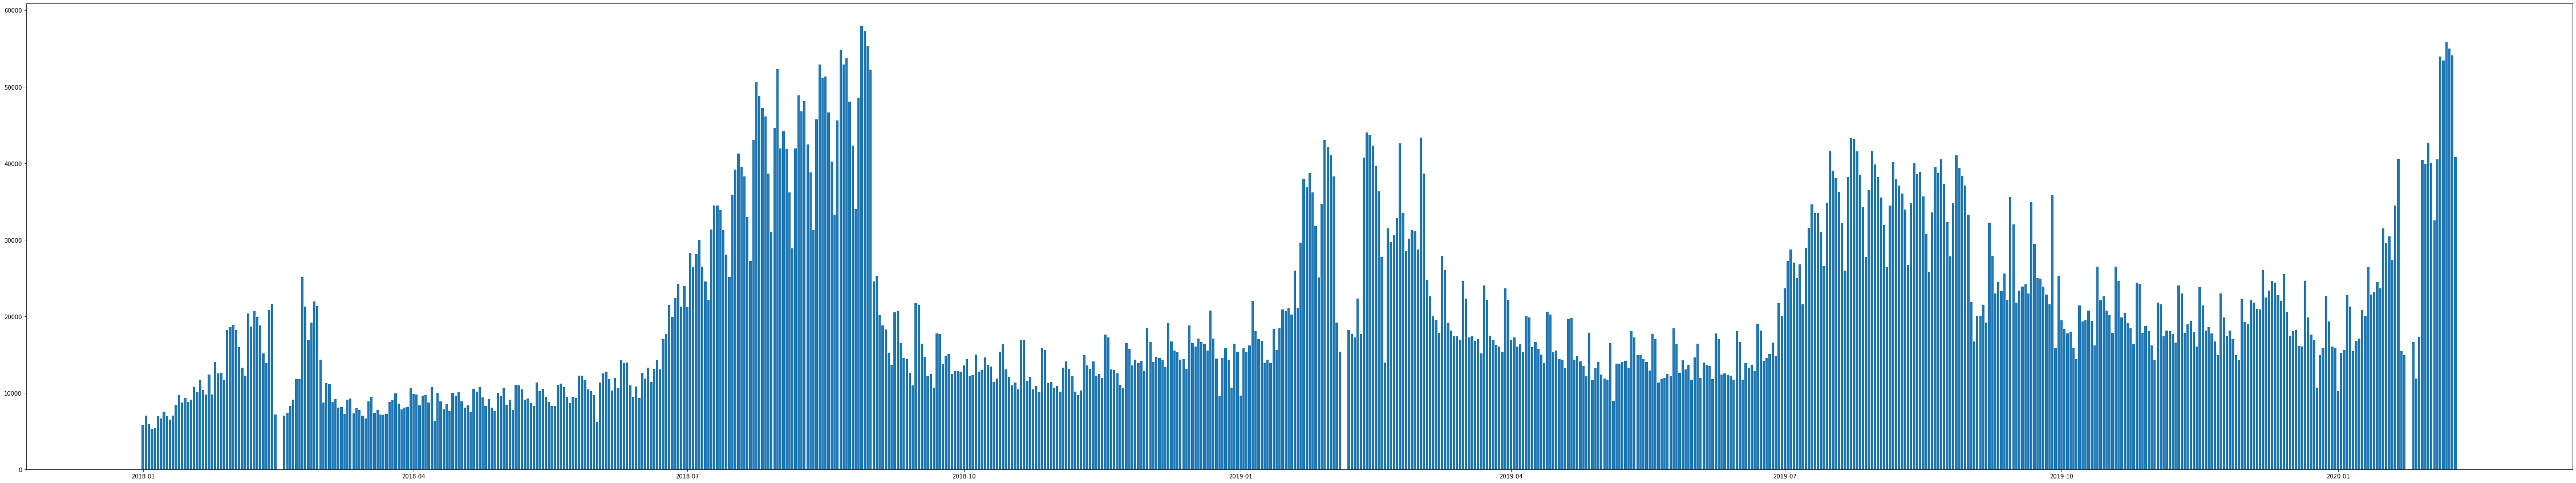

In [40]:
fig = plt.figure(2,figsize=(80, 15))
ax = fig.add_subplot()
ax.bar(historical_data_date.date.values, historical_data_date.cnt.values)
plt.show()

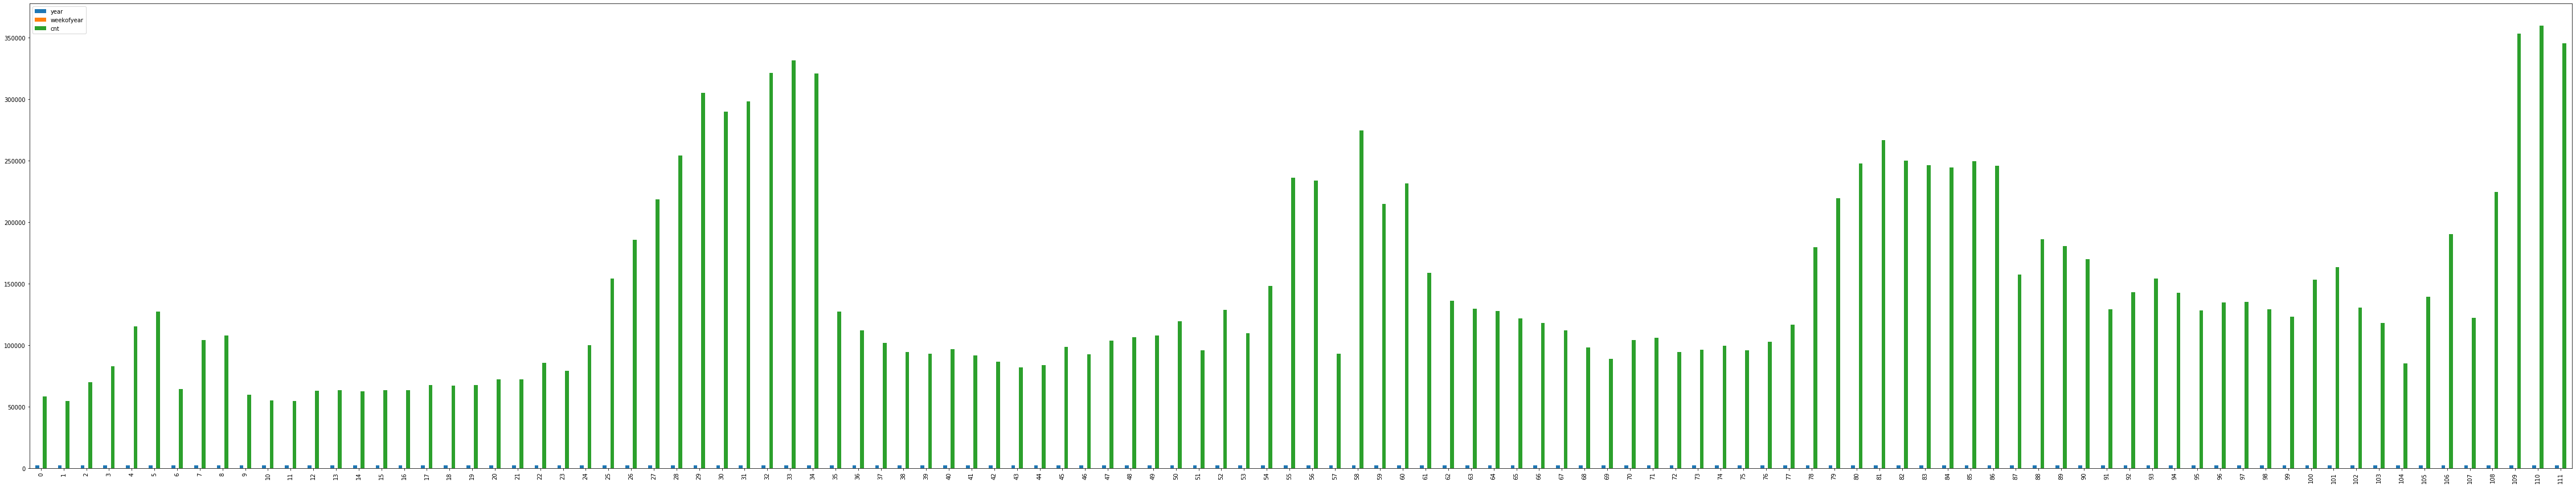

In [7]:
#按周聚合
historical_data_week = historical_data[['year','weekofyear','cnt']].groupby(['year','weekofyear']).sum().reset_index()
historical_data_week.plot(kind='bar',figsize=(80,15))

In [35]:
historical_data

,begin,cnt,time,date,time_index,dayofweek,weekofyear,year
0,2018-01-01 18:30:00,1173.0,18:30:00,2018-01-01,13,0,1,2018
1,2018-01-01 19:10:00,1573.0,19:10:00,2018-01-01,14,0,1,2018
2,2018-01-01 19:50:00,1706.0,19:50:00,2018-01-01,15,0,1,2018
3,2018-01-01 20:30:00,1322.0,20:30:00,2018-01-01,16,0,1,2018
4,2018-01-02 18:30:00,1560.0,18:30:00,2018-01-02,13,1,1,2018
...,...,...,...,...,...,...,...,...
5042,2020-02-23 17:50:00,1222.0,17:50:00,2020-02-23,12,6,8,2020
5043,2020-02-23 18:30:00,2673.0,18:30:00,2020-02-23,13,6,8,2020
5044,2020-02-23 19:10:00,3468.0,19:10:00,2020-02-23,14,6,8,2020
5045,2020-02-23 19:50:00,4067.0,19:50:00,2020-02-23,15,6,8,2020


#### 试一下tensorflow

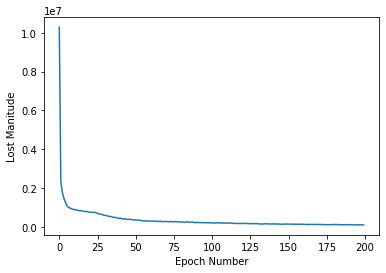

In [7]:
plt.xlabel('Epoch Number')
plt.ylabel('Lost Manitude')
plt.plot(history.history['loss'])

In [9]:
history.history['loss'][-1]

116575.11110982606

NameError: name 'Y' is not defined

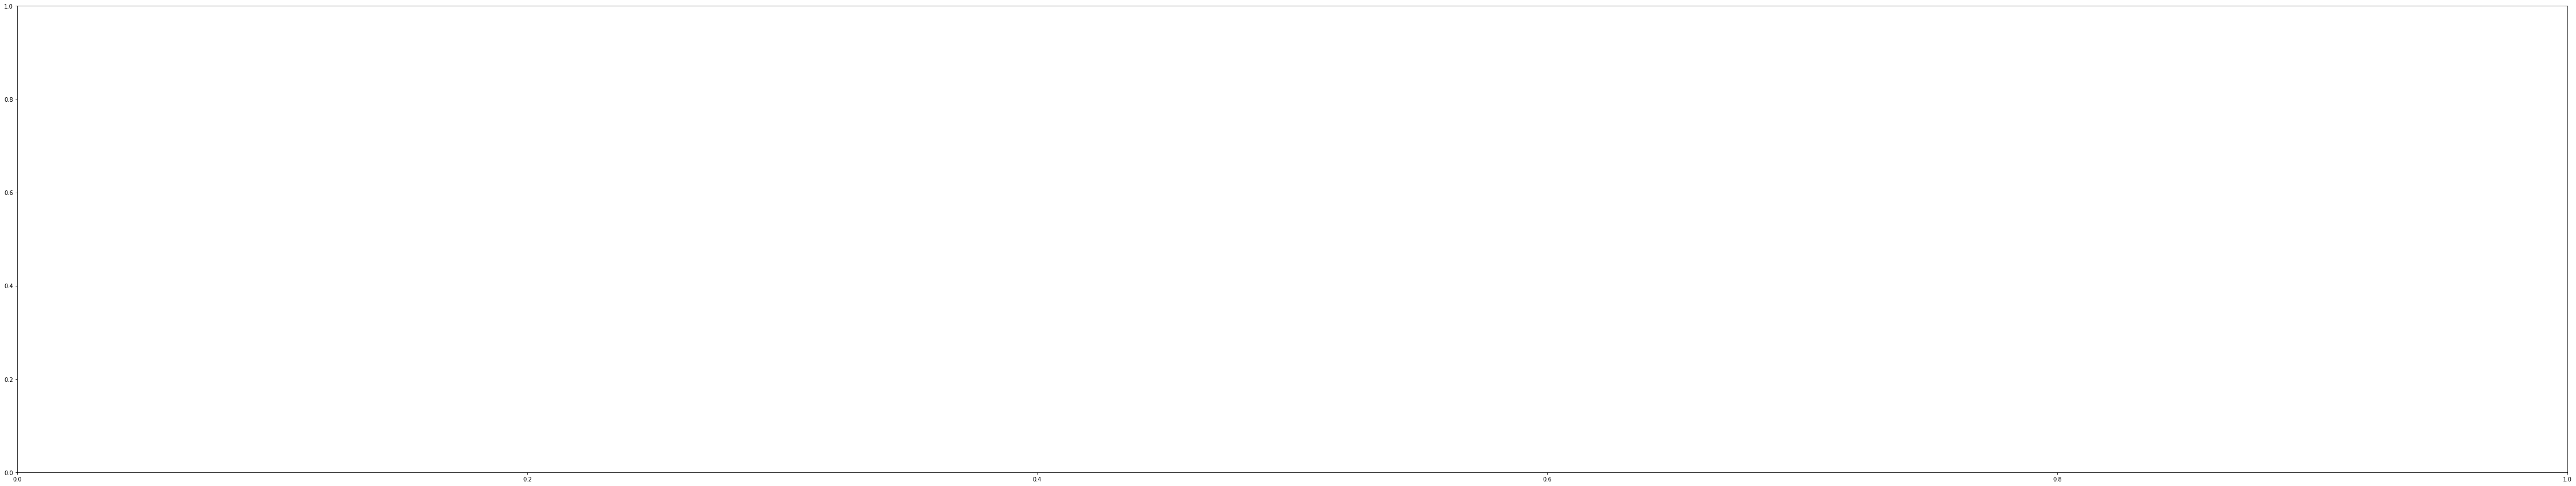

In [8]:
fig = plt.figure(3,figsize=(80, 15))
ax = fig.add_subplot()
ax.plot(dnn._df.index[-100:], Y[-100:], color='blue',alpha=0.5)
ax.scatter(dnn._df.index[-100:], model.predict(X[-100:]), color='red')
plt.show()

In [21]:
 model.predict(X)[-100:]

array([[3045.4587],
       [2926.5984],
       [2635.4875],
       [2137.903 ],
       [1309.7166],
       [ 751.4774],
       [ 751.4773],
       [ 751.4773],
       [ 751.4774],
       [ 751.4774],
       [1972.6787],
       [5007.398 ],
       [6044.946 ],
       [6278.6973],
       [5516.926 ],
       [1785.7896],
       [2940.2485],
       [3204.9167],
       [3126.4456],
       [2789.9714],
       [2243.0596],
       [1357.5063],
       [ 751.4774],
       [ 751.4774],
       [ 751.4774],
       [ 751.4774],
       [ 751.4774],
       [2203.26  ],
       [5012.7036],
       [6066.8643],
       [6319.3516],
       [5550.494 ],
       [1794.7949],
       [2817.493 ],
       [3070.8567],
       [2995.825 ],
       [2689.4592],
       [2179.7195],
       [1350.4602],
       [ 751.4773],
       [ 751.4774],
       [ 751.4774],
       [ 751.4774],
       [ 751.4774],
       [2182.1863],
       [4990.266 ],
       [5956.938 ],
       [6232.401 ],
       [5509.1987],
       [1728.9109],


#### 同样数据下GDBT的效果

In [18]:
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=5, random_state=12, loss='ls').fit(X, Y)

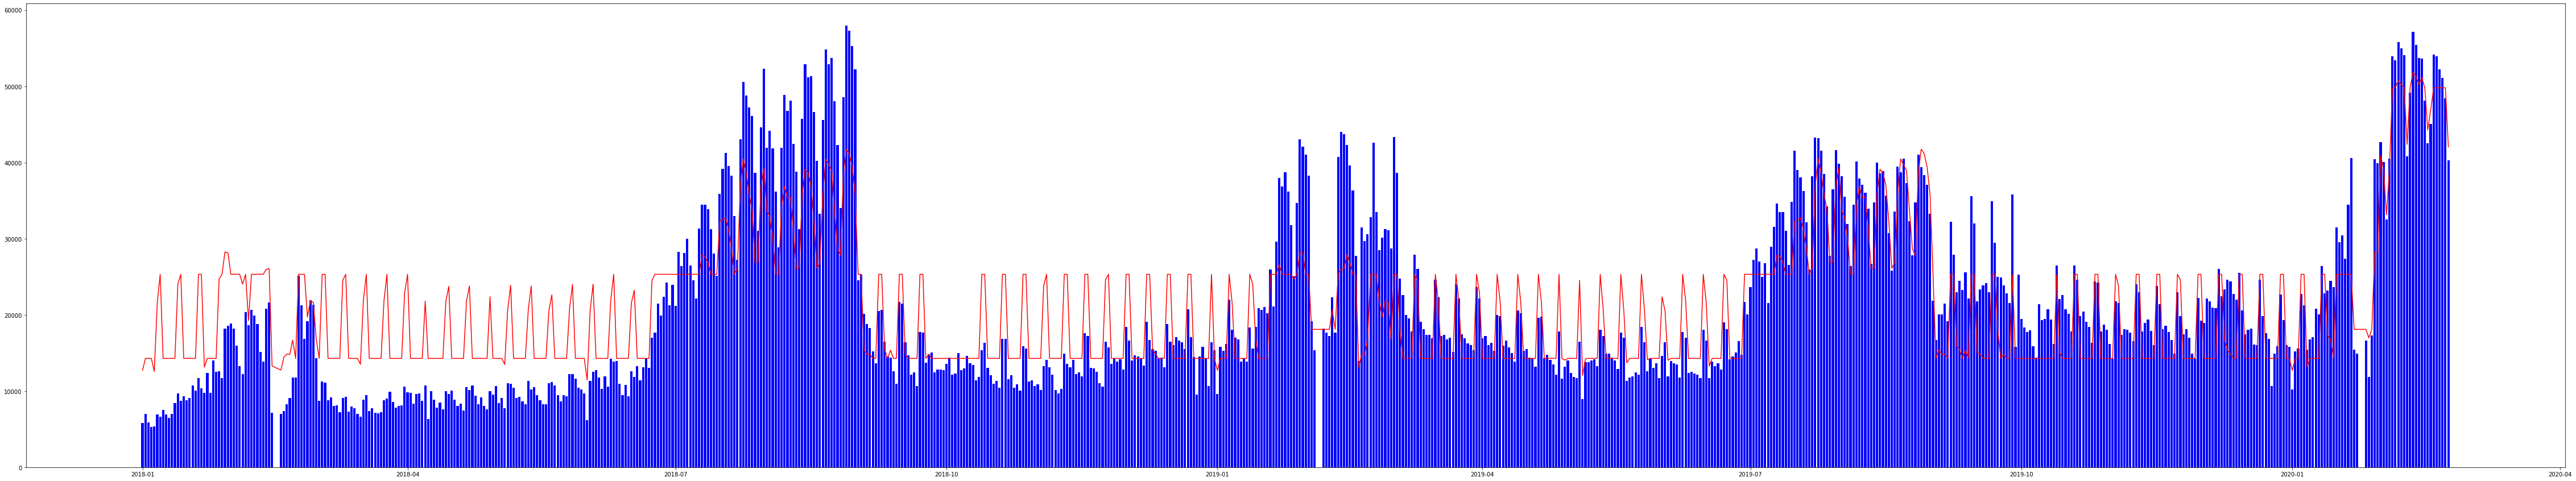

In [27]:
fig = plt.figure(4,figsize=(80, 15))
ax = fig.add_subplot()
ax.bar(one_hot_data.index, Y, color='blue')
ax.errorbar(one_hot_data.index, est.predict(X), color='red')
plt.show()

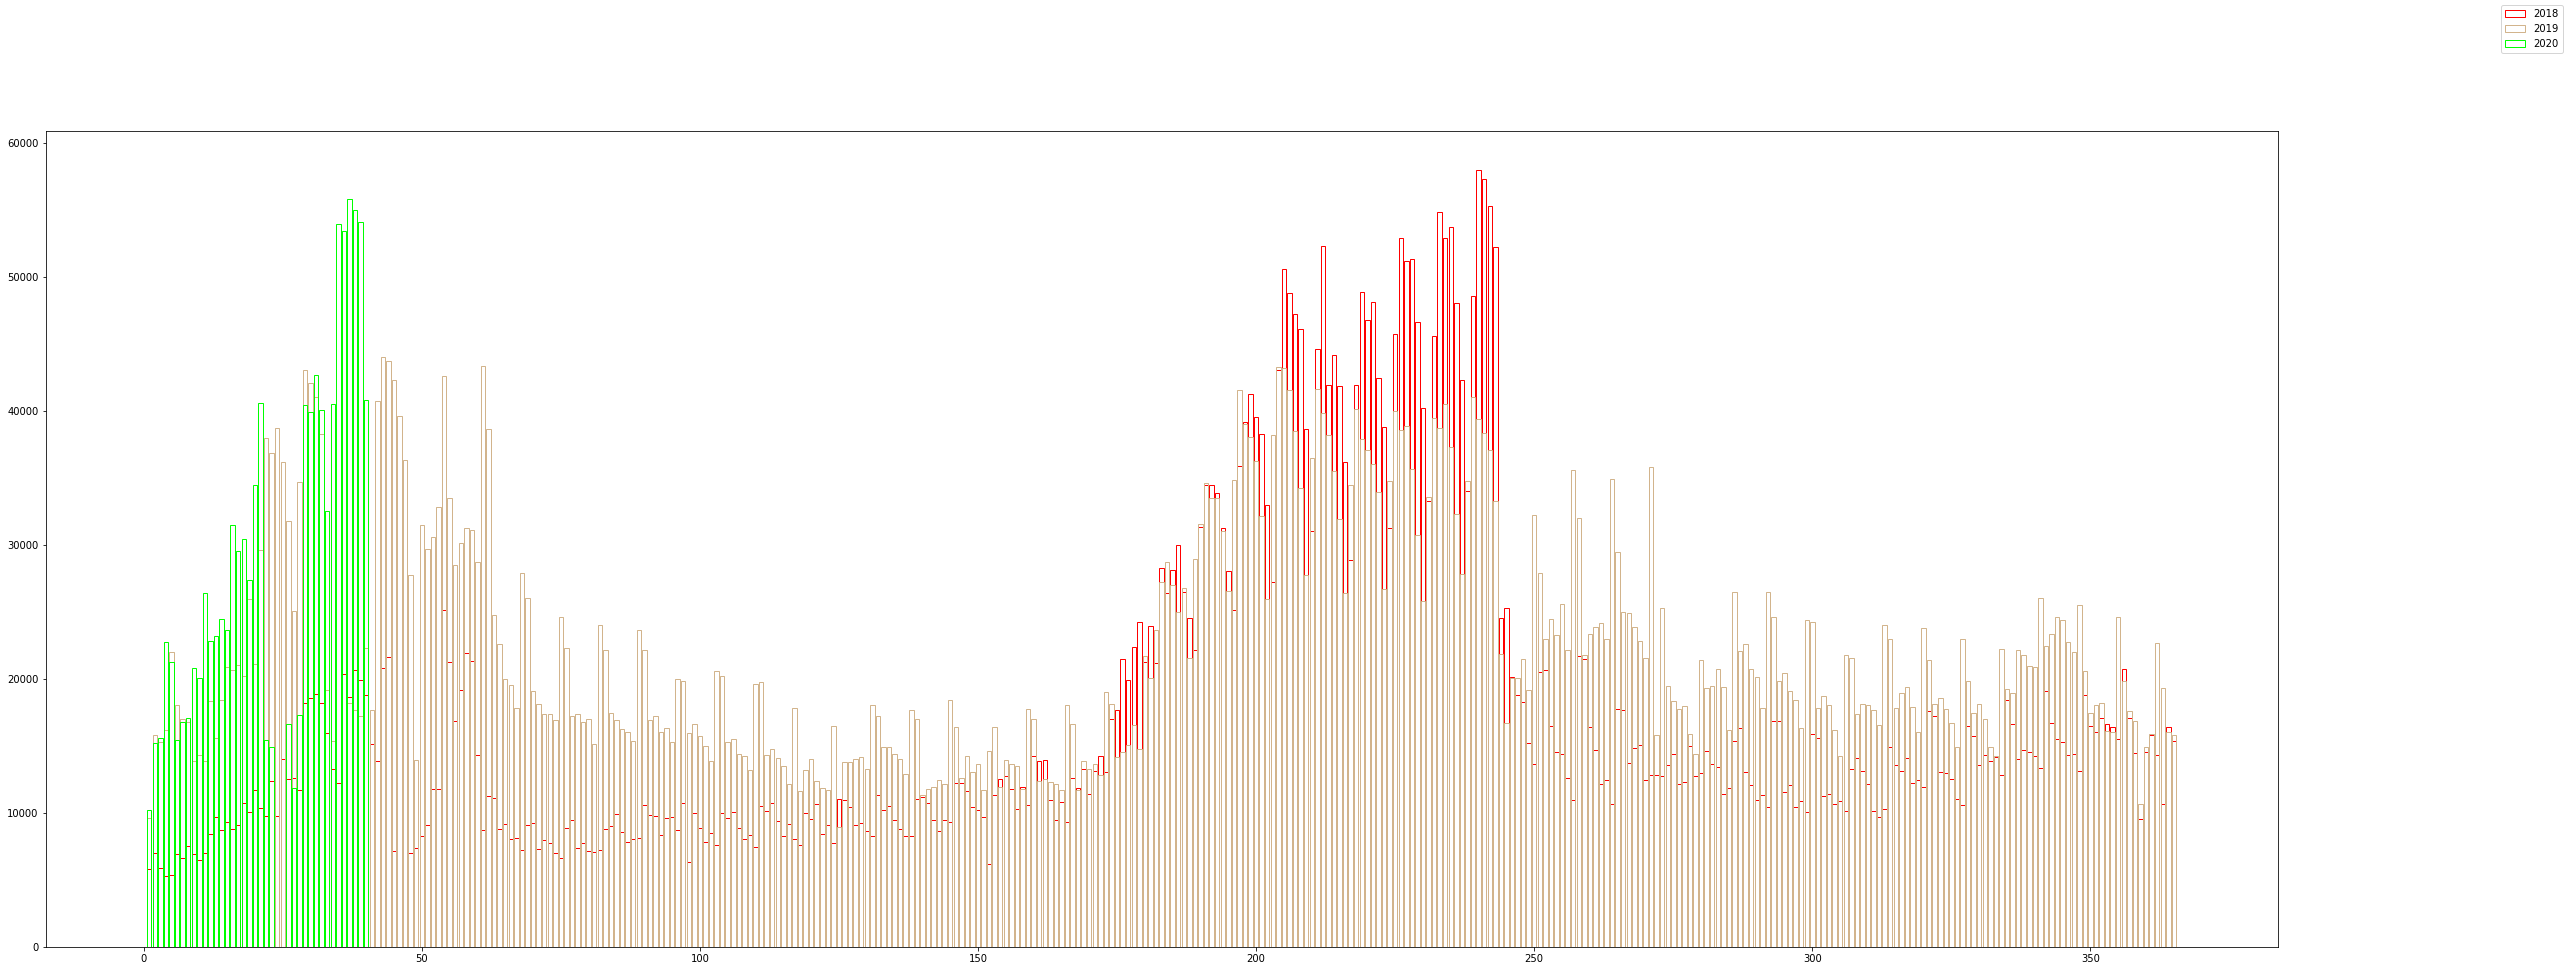

In [56]:
# 统计每年每天的学生总数
fig = plt.figure(3,figsize=(40, 15))
ax = fig.add_subplot()
colors = ['red', 'tan', 'lime']
color_index = 0
for year, data_of_year in historical_data_date.groupby('year'):
    ax.bar(data_of_year.dayofyear.values, data_of_year.cnt.values, edgecolor=colors[color_index],label = year, fill=False)
    color_index += 1
fig.legend()
plt.show()

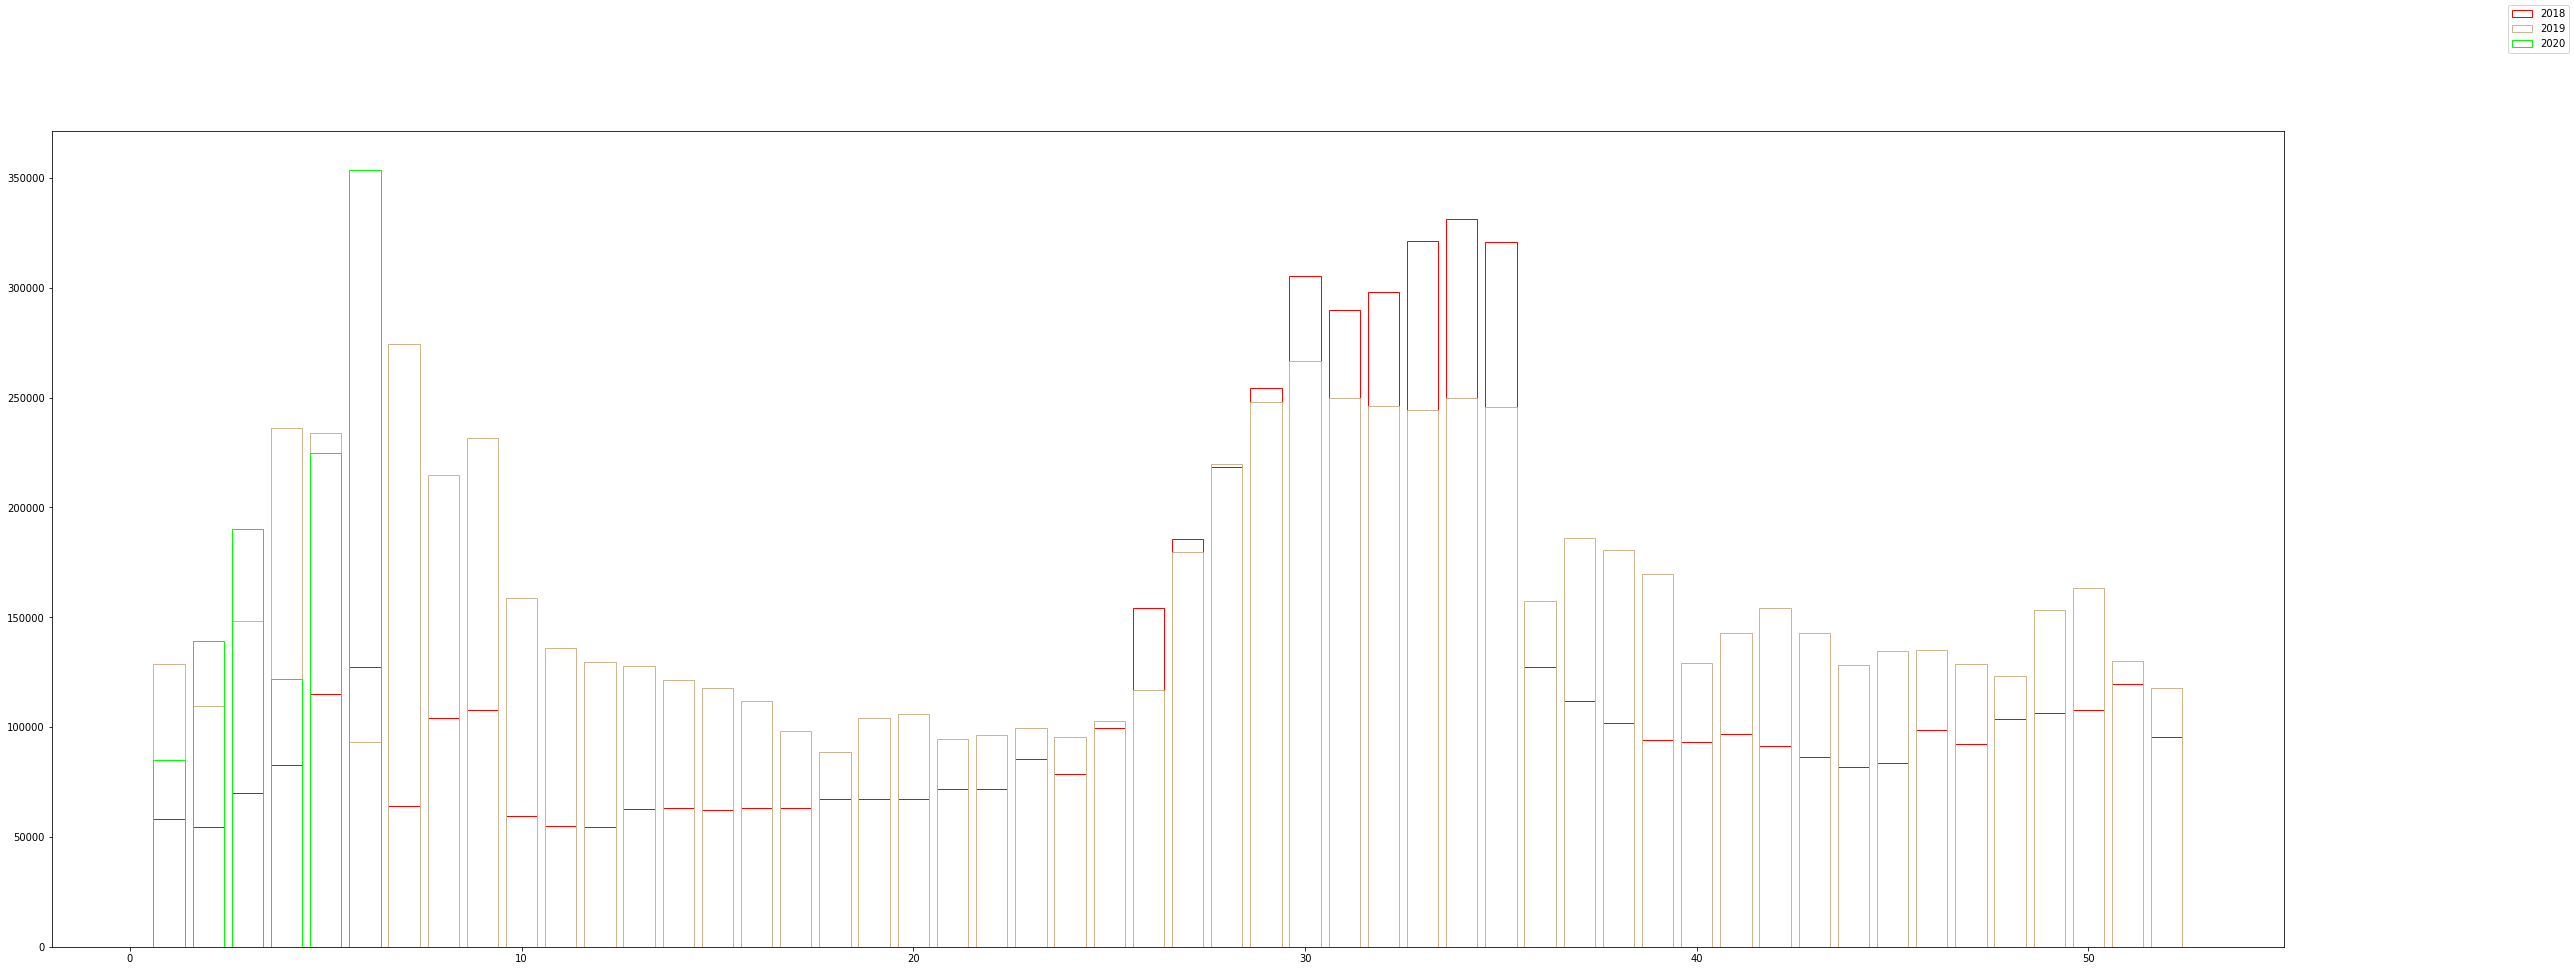

In [38]:
# 统计每年每周的学生总数
fig = plt.figure(3,figsize=(40, 15))
ax = fig.add_subplot()
colors = ['red', 'tan', 'lime']
color_index = 0
for year, data_of_year in historical_data_week.groupby('year'):
    ax.bar(data_of_year.weekofyear.values, data_of_year.cnt.values, edgecolor=colors[color_index],label = year, fill=False)
    color_index += 1
fig.legend()
plt.show()

### 线性回归
S为每天的学生数，M为上午学生上课的欲望，E为晚上学生上课的欲望，A为下午学生上课的欲望，C_M,C_E,C_A 为对应时间段上课的人数。先求出上课的欲望，然后线性回归。
优点：
1. 可以使用简单模型
2. 极大简化外部因素的影响（国家疫情，学校放假考试）

### 查看一年中不同周的数据情况

In [6]:
historical_data[['weekofyear','cnt']].groupby(['weekofyear']).describe()

cnt                                                     
              count       mean         std  min  25%   50%   75%     max
weekofyear                                                              
1           12392.0  21.948999   60.757379  1.0  2.0   7.0  21.0  1583.0
2           12601.0  24.108245   68.124103  1.0  2.0   7.0  23.0  2143.0
3           14152.0  28.857759   56.967861  1.0  3.0   9.0  32.0  1199.0
4           14491.0  30.433165   60.392167  1.0  2.0   9.0  35.0  1121.0
5           18780.0  30.543024   57.597961  1.0  3.0   9.0  35.0  1226.0
6            6559.0  33.619302   52.117519  1.0  4.0  15.0  40.0   541.0
7            8873.0  38.137947   67.978620  1.0  3.0  15.0  45.0   894.0
8            7286.0  43.749657   82.362782  1.0  4.0  17.0  47.0  1123.0
9            7142.0  47.532764   90.017853  1.0  4.0  15.0  48.0   941.0
10           7686.0  28.415040   52.474954  1.0  3.0  10.0  29.0   743.0
11           8170.0  23.351163   41.387890  1.0  3.0   8.0  24.0   437.0
12           8077.0  22.788040   39.862258  1.0  3.0   7.0  22.0   406.0
13           8279.0  23.036357   40.930017  1.0  2.0   8.0  23.0   503.0
14           8223.0  22.464186   37.308746  1.0  3.0   8.0  23.0   371.0
15           8888.0  20.278128   34.286832  1.0  2.0   7.0  22.0   395.0
16           8840.0  19.833145   33.151739  1.0  3.0   7.0  22.0   382.0
17           7810.0  20.659283   33.944801  1.0  3.0   8.0  23.0   404.0
18           8222.0  18.988081   29.938121  1.0  2.0   7.0  21.0   323.0
19           8909.0  19.245482   34.074570  1.0  2.0   7.0  20.0   371.0
20           9099.0  19.038905   33.282975  1.0  2.0   7.0  20.0   395.0
21           9118.0  18.250603   31.347431  1.0  2.0   6.0  20.0   399.0
22           9085.0  18.524601   40.925088  1.0  2.0   6.0  18.0   677.0
23           8897.0  20.780263   47.400259  1.0  2.0   6.0  18.0   650.0
24           8932.0  19.535938   52.191925  1.0  2.0   5.0  15.0   951.0
25           9247.0  21.876717   53.873002  1.0  2.0   6.0  18.0   839.0
26          10689.0  25.350922   55.115514  1.0  2.0   7.0  24.0   826.0
27          13028.0  28.066856   75.926167  1.0  2.0   7.0  24.0  1329.0
28          13989.0  31.313032   87.646635  1.0  2.0   7.0  27.0  1535.0
29          14876.0  33.748118   97.081790  1.0  2.0   7.0  28.0  1649.0
30          15049.0  38.012758  110.640061  1.0  2.0   7.0  31.0  1893.0
31          15203.0  35.511149   87.415863  1.0  2.0   8.0  31.0  1379.0
32          15417.0  35.299150   85.143456  1.0  2.0   8.0  32.0  1111.0
33          15655.0  36.124369   87.483259  1.0  2.0   8.0  33.0  1123.0
34          15903.0  36.540590   88.759538  1.0  2.0   8.0  33.0  1266.0
35          16000.0  35.416812   86.903303  1.0  3.0   8.0  32.0  1242.0
36           9936.0  28.662641   63.139850  1.0  3.0   8.0  26.0   954.0
37           9917.0  30.043965   69.945208  1.0  3.0   8.0  26.0  1152.0
38          10133.0  27.840817   65.918445  1.0  2.0   7.0  26.0  1157.0
39           8745.0  30.206061   69.893589  1.0  2.0   8.0  26.0  1040.0
40           8150.0  27.259387   53.175311  1.0  3.0   8.0  27.0   927.0
41           9644.0  24.834197   52.129566  1.0  2.0   7.0  22.0   740.0
42          10592.0  23.210819   49.332212  1.0  2.0   6.0  20.0   818.0
43          10812.0  21.196726   43.443511  1.0  2.0   6.0  19.0   727.0
44          10638.0  19.752209   39.737652  1.0  2.0   6.0  18.0   667.0
45          10627.0  20.568364   41.462778  1.0  2.0   6.0  18.0   654.0
46          10539.0  22.172312   50.803959  1.0  2.0   6.0  19.0   866.0
47          10552.0  20.978582   48.921295  1.0  2.0   6.0  18.0   937.0
48          10515.0  21.579648   53.246104  1.0  2.0   6.0  20.0  1101.0
49          10450.0  24.861722   59.696022  1.0  2.0   7.0  23.0  1099.0
50          10854.0  24.974756   62.338376  1.0  2.0   6.0  21.0  1183.0
51          10934.0  22.839126   58.567184  1.0  2.0   6.0  19.0  1150.0
52           9871.0  21.628305   60.440527  1.0  2.0   5.0  18.0  1245.0

### 按天计算总人数

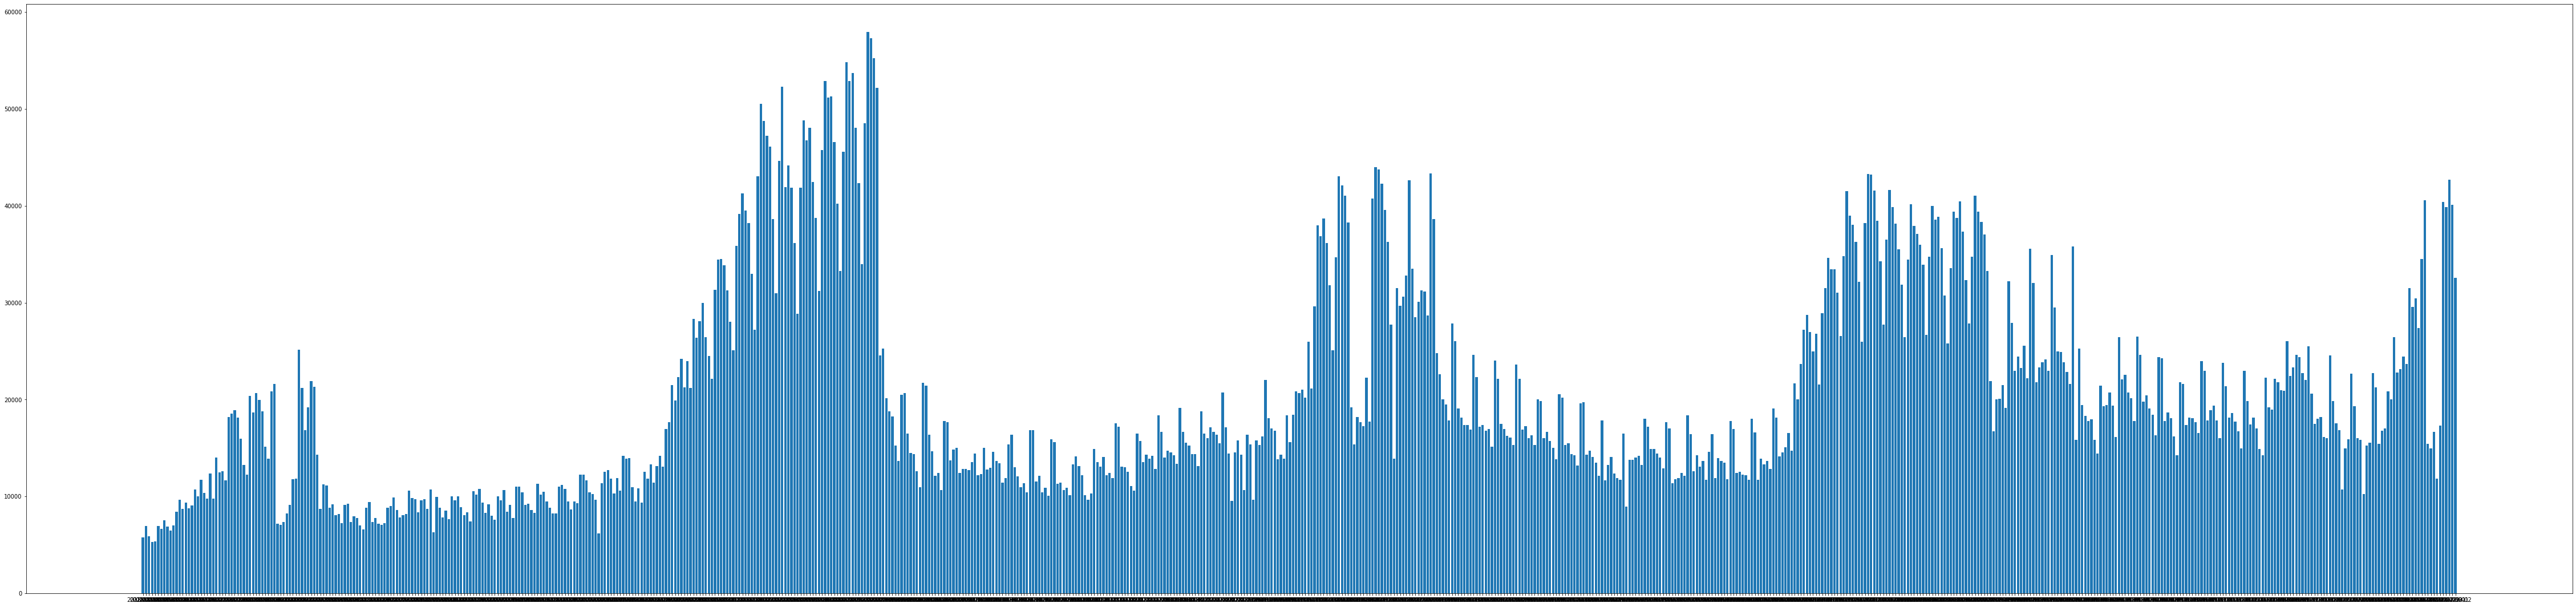

In [7]:
historical_data_cnt =  historical_data[['date', 'cnt']].groupby('date').sum()
fig = plt.figure(1,figsize=(80, 19))
ax = fig.add_subplot(1,1,1)
ax.bar(historical_data_cnt.index, historical_data_cnt.cnt.values)
plt.show()

# 模型

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [56]:
# 交叉验证
def split_data(data,frac = 0.2):
    return np.split(data.sample(frac=1), [int(frac*len(data))])

def rsquare(a, b):
    return np.square(a - b.mean()).sum() / np.square(b - b.mean()).sum()

def fitter_dbr(data, features, param, scale = None):
    test, train = split_data(data)
    x_train = train[features].values
    y_train = train[param].values
    x_test = test[features].values
    y_test = test[param].values
    est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=5, random_state=12, loss='ls').fit(x_train, y_train)

    mse = mean_squared_error(y_test, est.predict(x_test))
    print(f"mean squared error: {mse}")
    data['predict'] = est.predict(data[features].values)
    rs = est.score(data[features].values ,data[param].values)
    print(f"R-square: {rs}")
    r2 = r2_score(data['predict'].values ,data[param].values)
    print(f"r2 : {r2}")
    r3 = rsquare(data['predict'].values ,data[param].values)
    print(f"rsquare : {r3}")
    tmp = data[['date', param, 'predict']].groupby('date').sum()
    r4 = rsquare(tmp['predict'].values ,tmp[param].values)
    print(f"day rsquare : {r3}")
    fig, ax = plt.subplots(figsize=(80, 19))
    sub = -1000
    ax.bar(tmp.index[sub:], tmp[param].values[sub:], label=param)
    ax.scatter(tmp.index[sub:], tmp['predict'].values[sub:], alpha=0.4, color='red')
    plt.show()

### GradientBoostingRegressor

mean squared error: 1033.1669383118751
R-square: 0.7479222249273445
r2 : 0.5850625950245687
rsquare : 0.6075079647415675
day rsquare : 0.6075079647415675


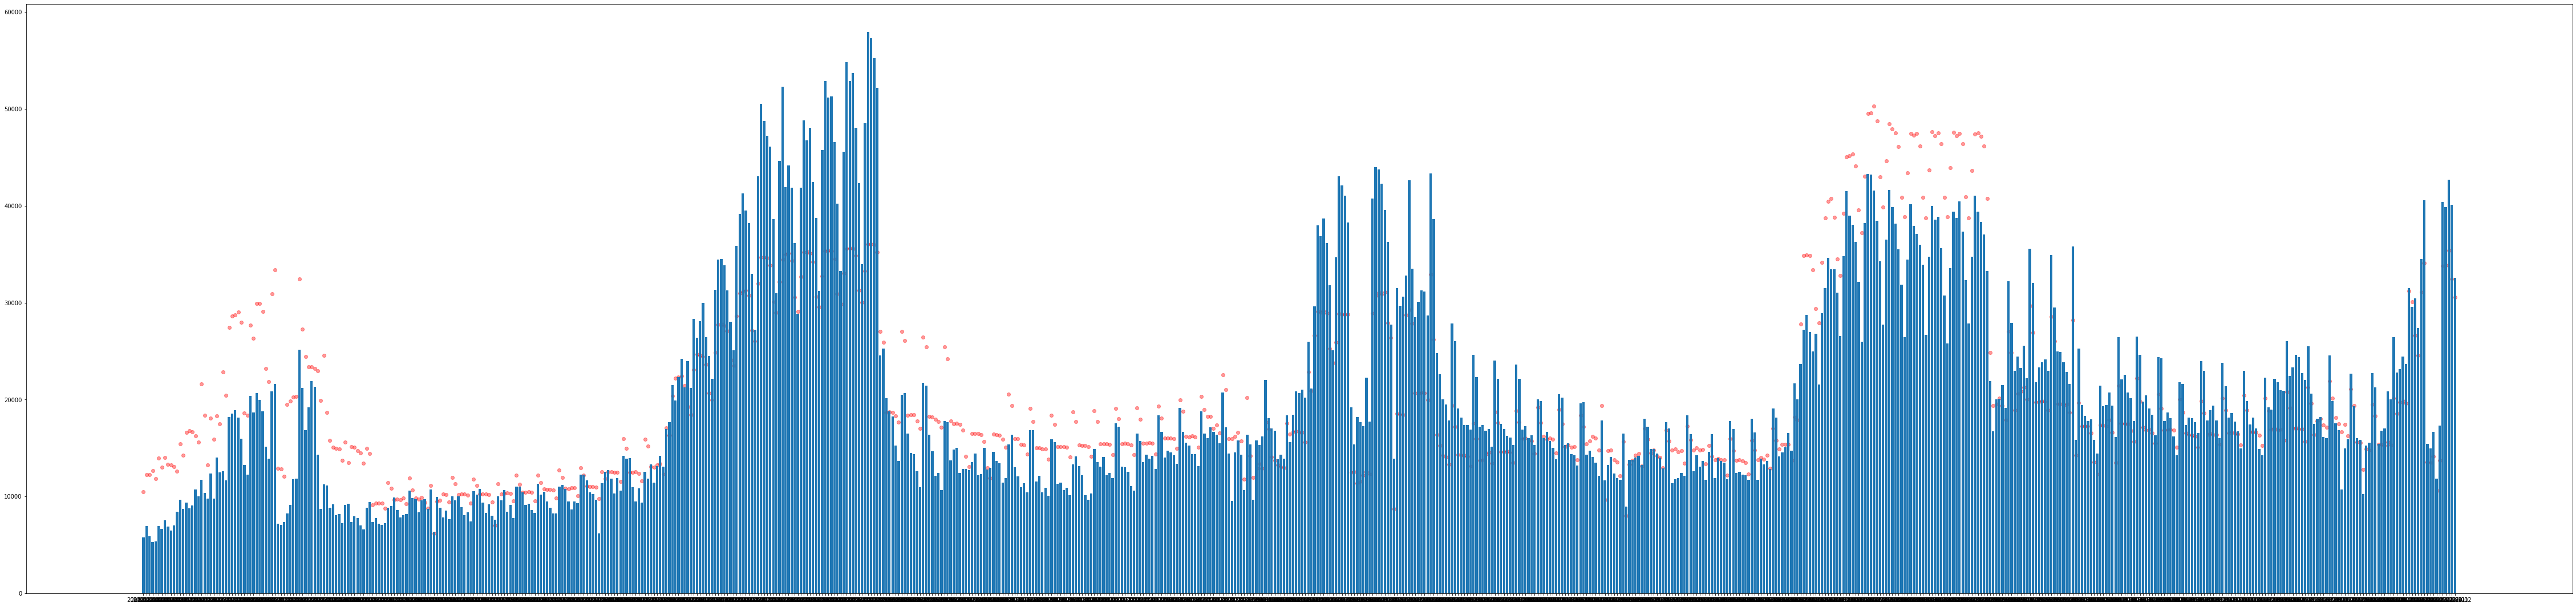

In [57]:
fitter_dbr(historical_data, ['chapter', 'roomtype', 'time_index',  'dayofweek', 'dayofyear', 'weekofyear'], 'cnt')

#### DecisionTreeRegressor

mean squared error: 4441.075418044866
R-square: 0.38043244471279536


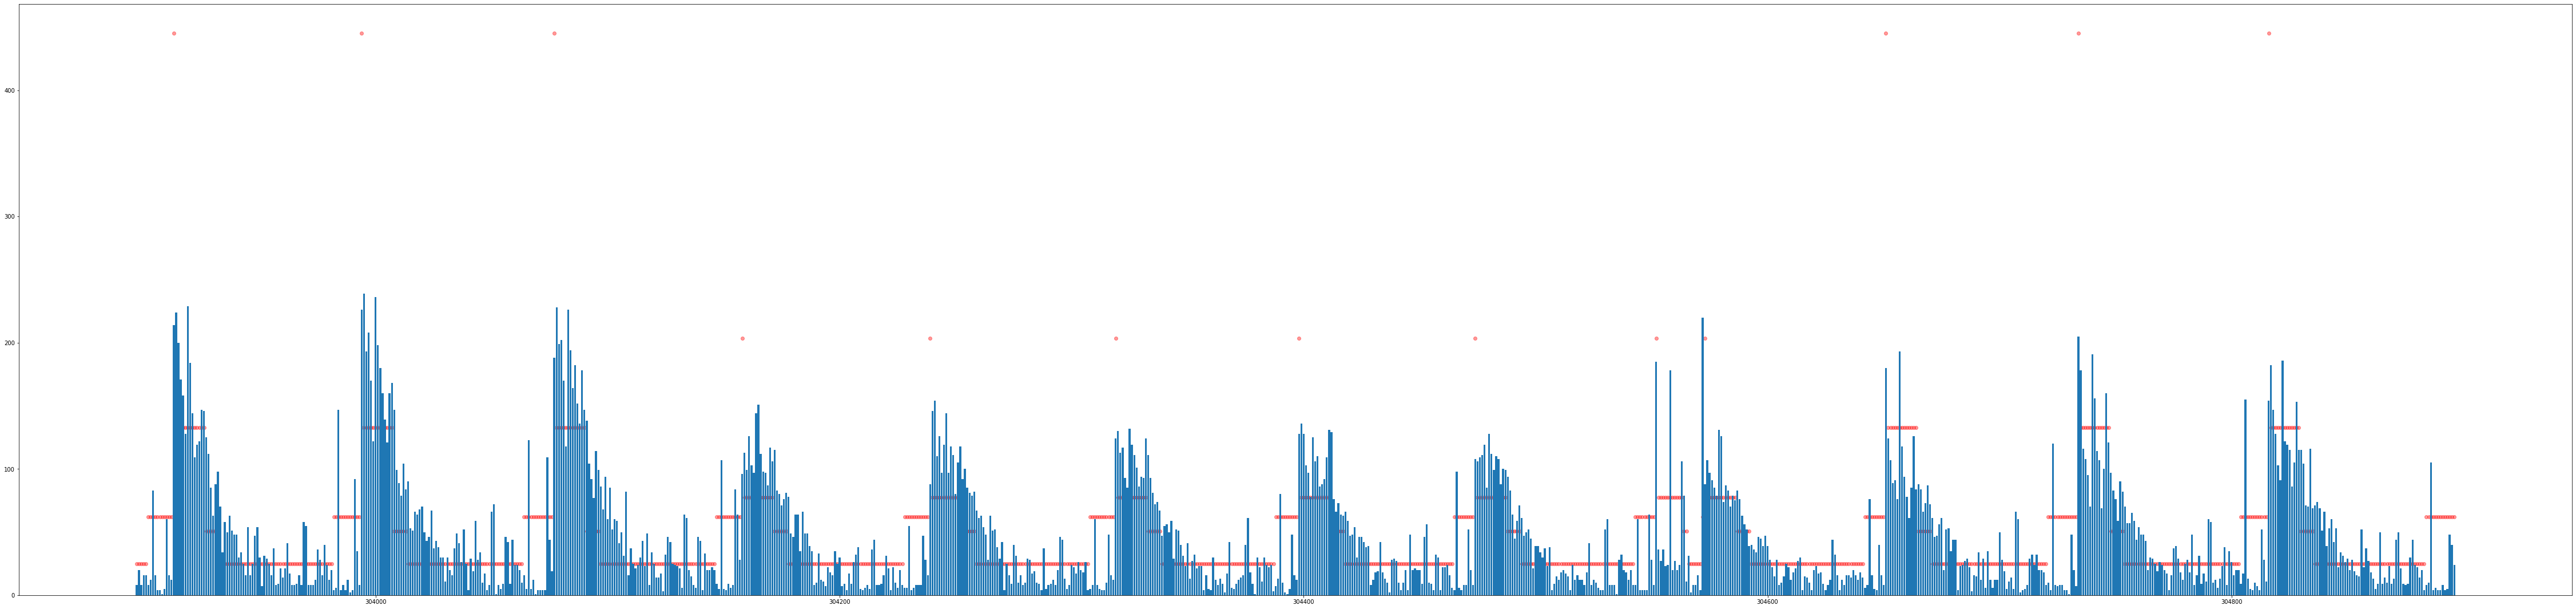

In [29]:
fitter_dtr(historical_data, ['chapter','time_index',  'dayofweek', 'weekofyear'], 'cnt')

#### 对y使用自然对数 （效果有提升）

mean squared error: 0.42430570473944834
R-square: 0.814166361041569


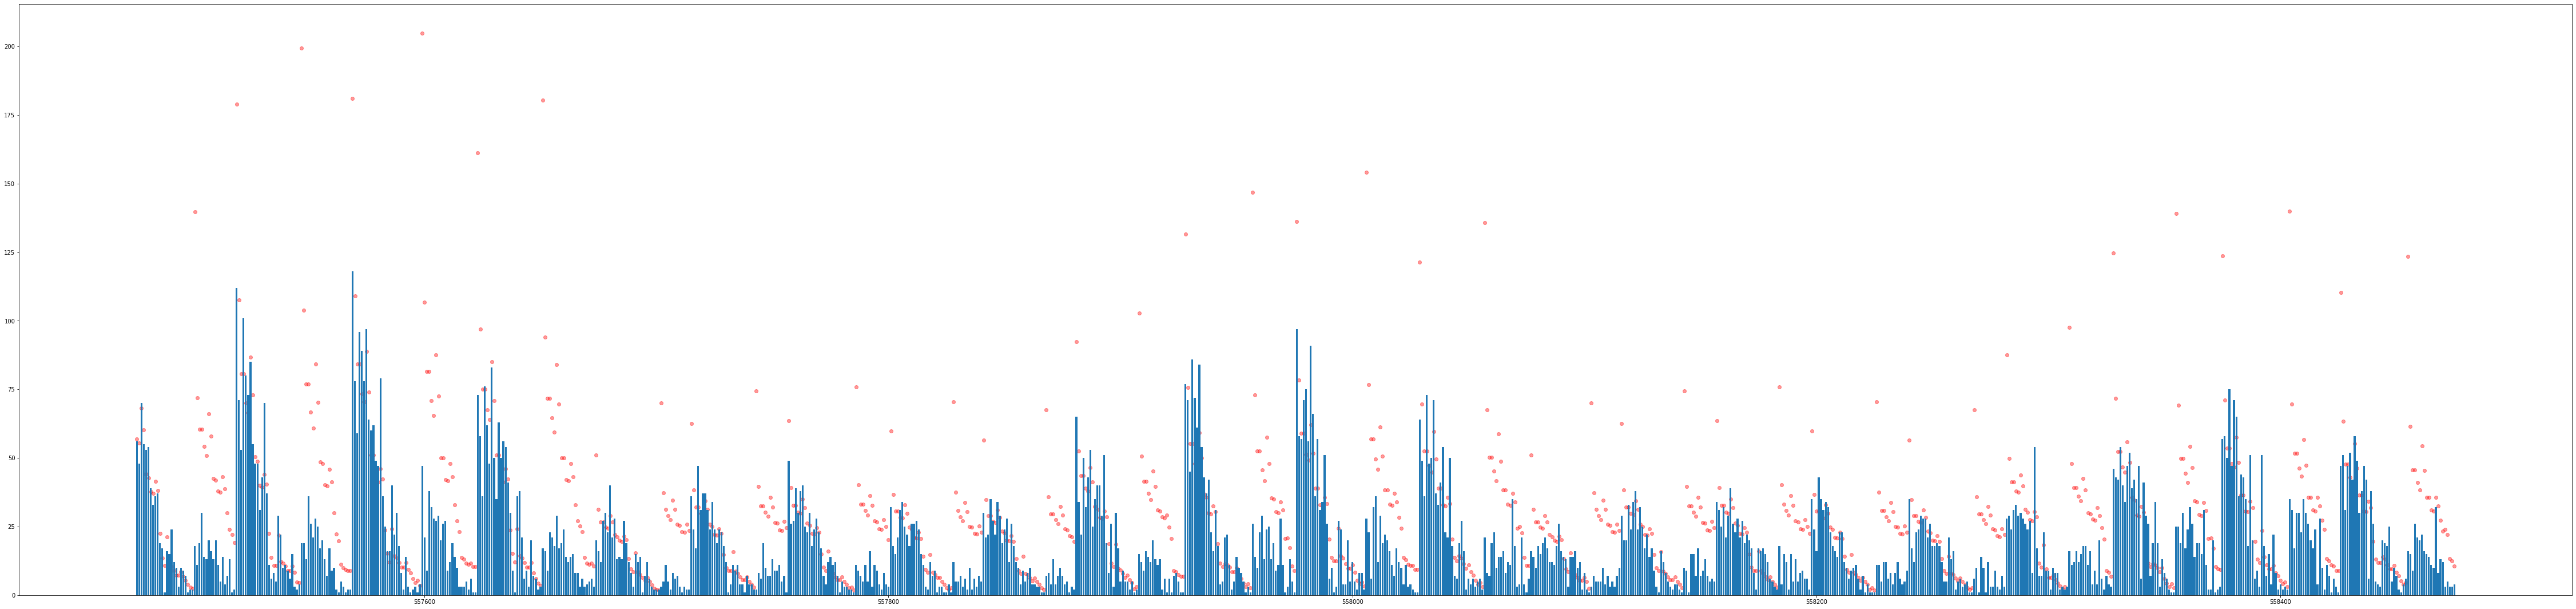

In [58]:
test, train = split_data(historical_data)
features = ['chapter', 'roomtype', 'time_index', 'dayofweek','weekofyear']
param = 'cnt'
x_train = train[features].values
y_train = train.cnt.apply(np.log).values
x_test = test[features].values
y_test = test.cnt.apply(np.log).values

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=5, random_state=12, loss='ls').fit(x_train, y_train)

mse = mean_squared_error(y_test, est.predict(x_test))
print(f"mean squared error: {mse}")
rs = est.score(historical_data[features].values ,historical_data[param].apply(np.log).values)
print(f"R-square: {rs}")
preict_data = est.predict(historical_data[features].values)
fig, ax = plt.subplots(figsize=(80, 19))
sub = -1000
ax.bar(historical_data.index[sub:], historical_data.cnt.values[sub:])
ax.scatter(historical_data.index[sub:], np.exp(preict_data)[sub:], alpha=0.4, color='red')
plt.show()

#### 对y使用平方根

mean squared error: 2.272633344337305
R-square: 0.8155165866294805


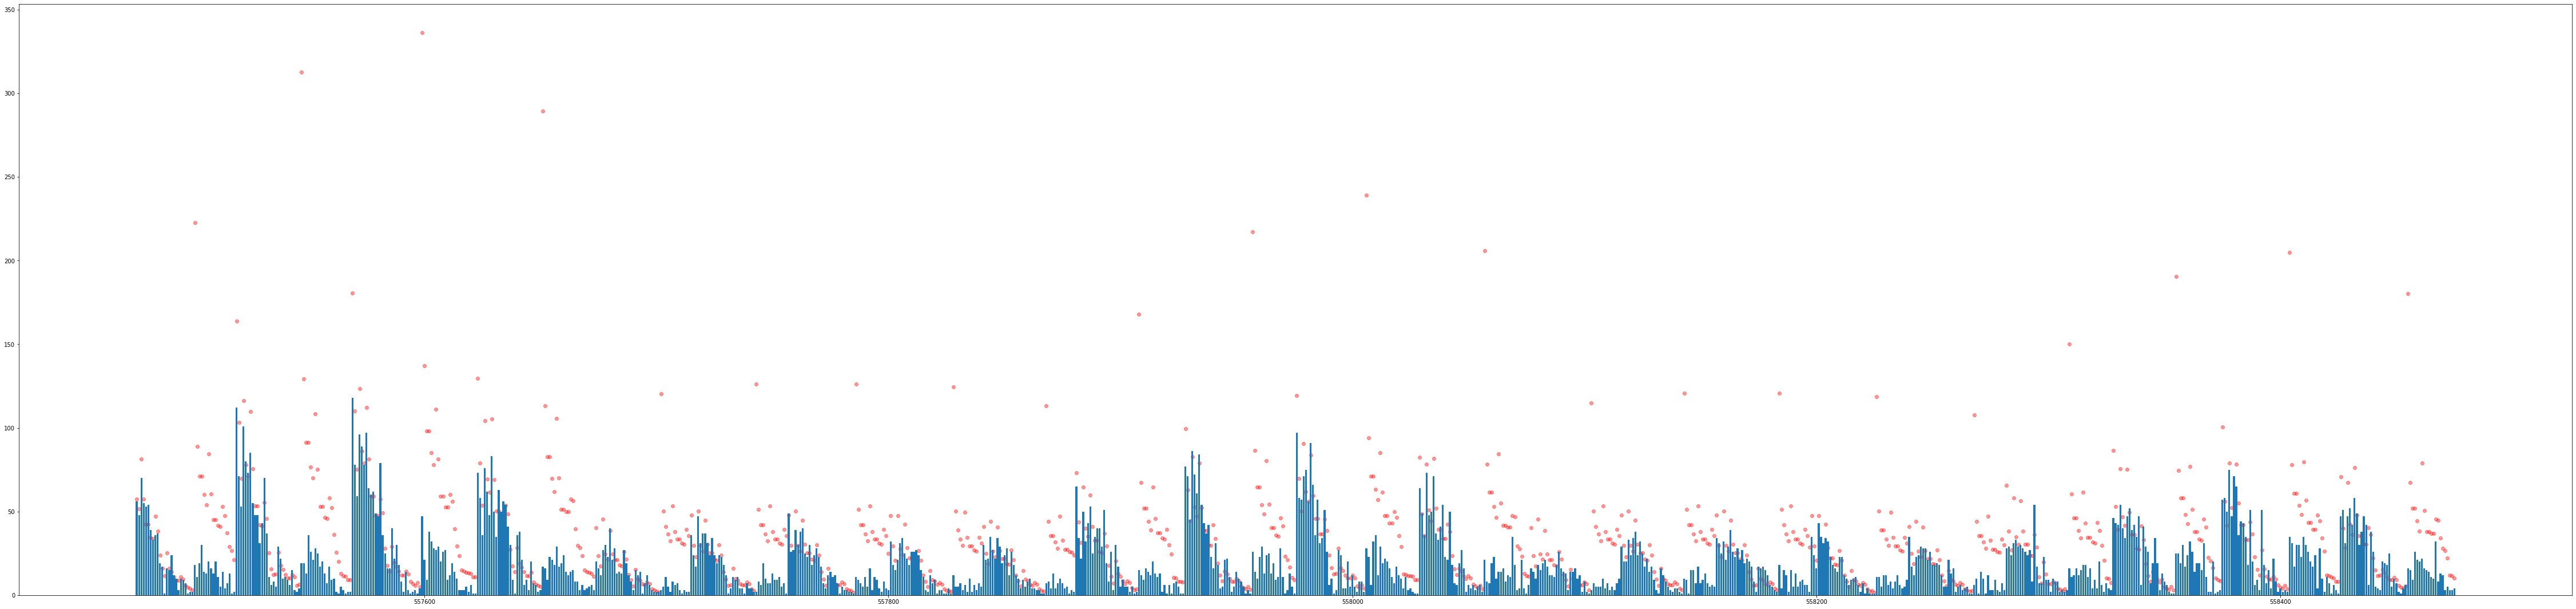

In [59]:
y_train = train.cnt.apply(np.sqrt).values
y_test = test.cnt.apply(np.sqrt).values

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=5, random_state=12, loss='ls').fit(x_train, y_train)

mse = mean_squared_error(y_test, est.predict(x_test))
print(f"mean squared error: {mse}")
rs = est.score(historical_data[features].values ,historical_data[param].apply(np.sqrt).values)
print(f"R-square: {rs}")
preict_data = est.predict(historical_data[features].values)
fig, ax = plt.subplots(figsize=(80, 19))
sub = -1000
ax.bar(historical_data.index[sub:], historical_data.cnt.values[sub:])
ax.scatter(historical_data.index[sub:], np.square(preict_data)[sub:], alpha=0.4, color='red')
plt.show()

#### 对学生人数进行scale

mean squared error: 3.9690571009372744
R-square: 0.714649979051349


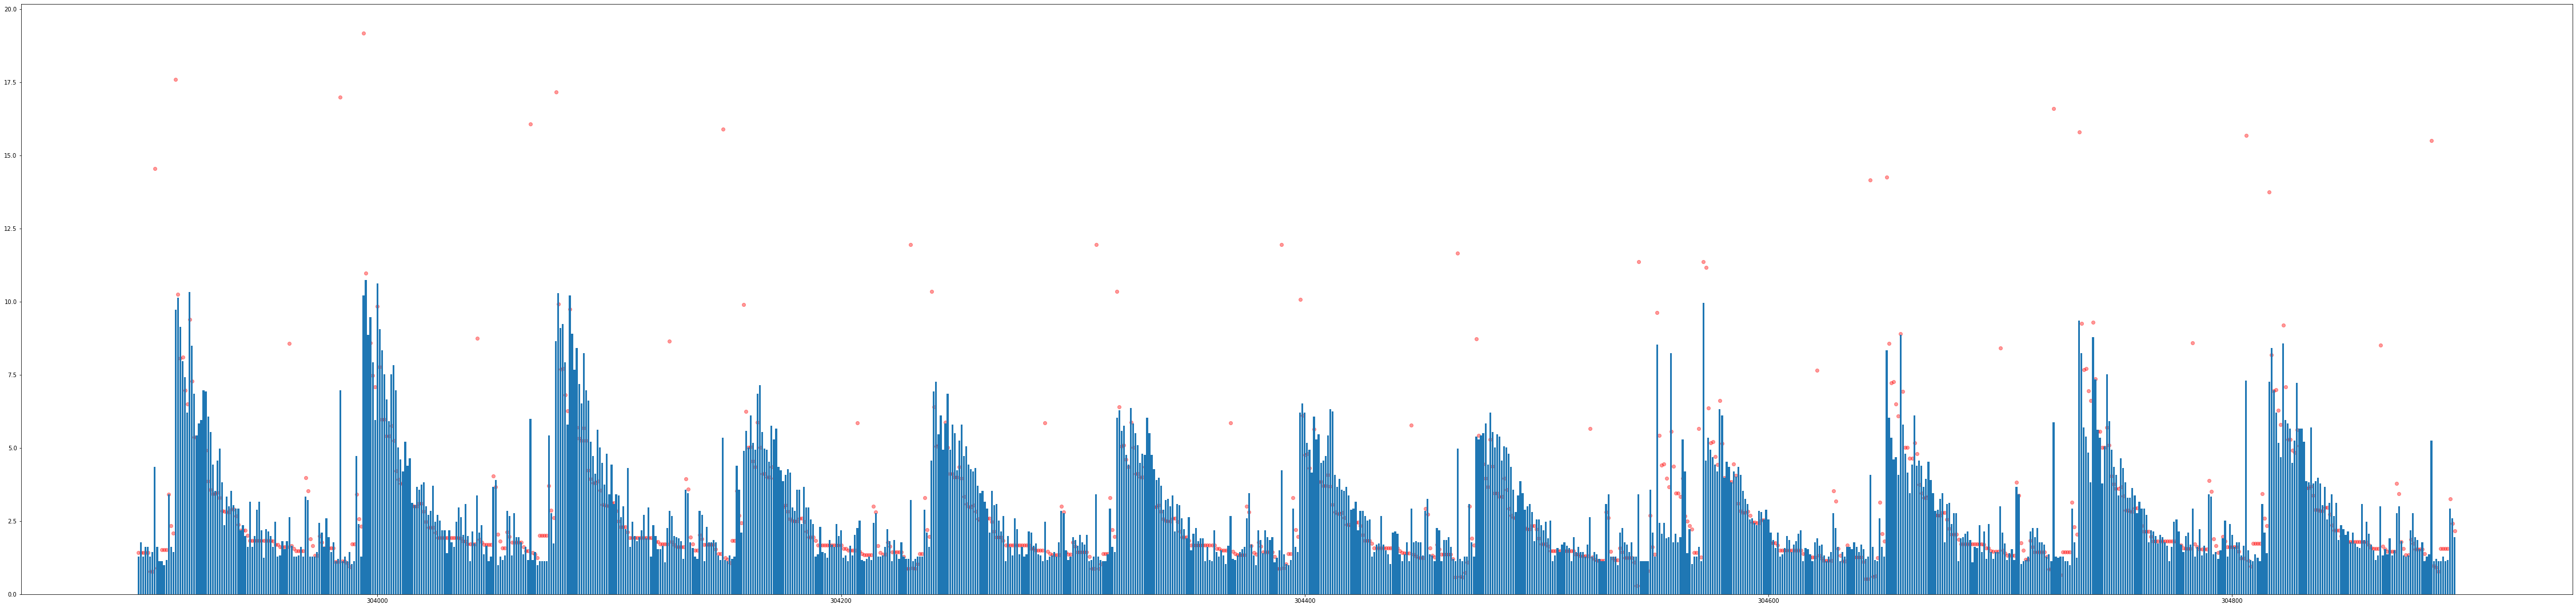

In [58]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
robust_scaler = MinMaxScaler(feature_range=(1,100)).fit(historical_data.cnt.values.reshape(-1,1))
historical_data['scale_cnt'] = robust_scaler.transform(historical_data.cnt.values.reshape(-1,1))
# fitter_dbr(historical_data, ['time_index',  'dayofweek', 'weekofyear'], 'scale_cnt')


test, train = split_data(historical_data)
features = ['chapter', 'time_index', 'dayofweek','weekofyear']
param = 'scale_cnt'
x_train = train[features].values
y_train = train[param].values
x_test = test[features].values
y_test = test[param].values

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=4, random_state=12, loss='ls').fit(x_train, y_train)

mse = mean_squared_error(y_test, est.predict(x_test))
print(f"mean squared error: {mse}")
rs = est.score(historical_data[features].values ,historical_data[param].values)
print(f"R-square: {rs}")
preict_data = est.predict(historical_data[features].values)
fig, ax = plt.subplots(figsize=(80, 19))
sub = -1000
ax.bar(historical_data.index[sub:], historical_data[param].values[sub:])
ax.scatter(historical_data.index[sub:], preict_data[sub:], alpha=0.4, color='red')
plt.show()

### 将chapter聚合后在拟合

mean squared error: 904026.4248074562
R-square: 0.7544788867385621
r2 : 0.6661674849213207
rsquare : 0.735507662809548
day rsquare : 0.735507662809548


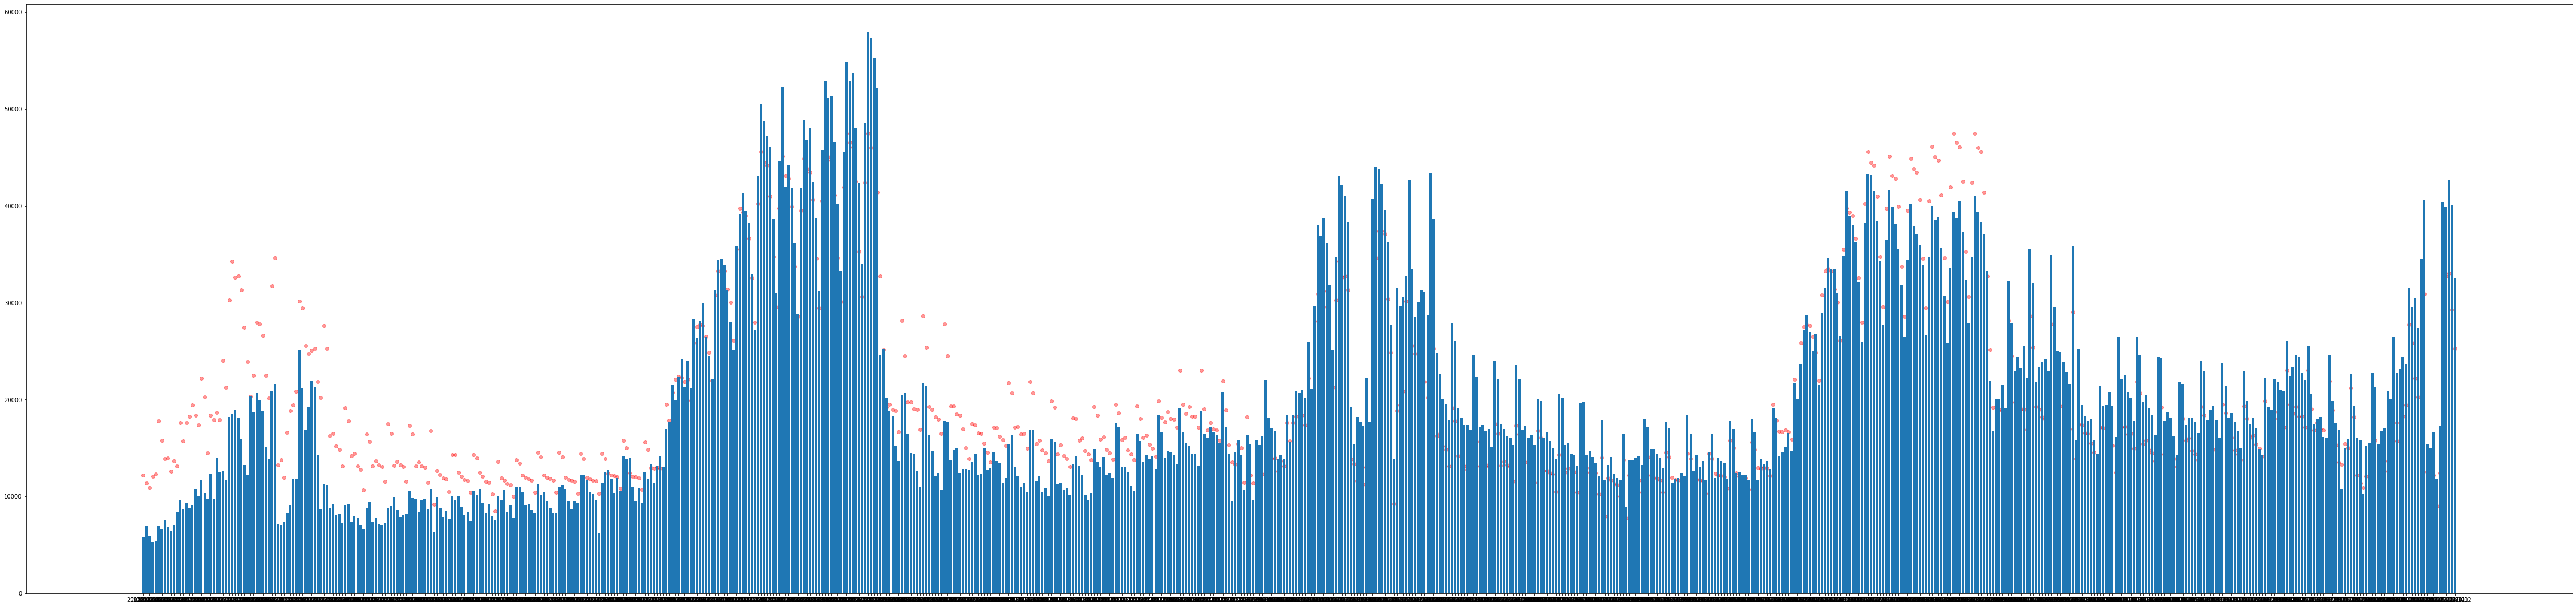

In [64]:
historical_data['time_index'] = historical_data.time.apply(lambda x: week.day_times.index(x))
fitter_dbr(historical_data_chapter, ['time_index', 'dayofweek', 'weekofyear'], 'cnt')

#### 再次使用自然对数

mean squared error: 0.12141319420635634
R-square: 0.7423299755048919


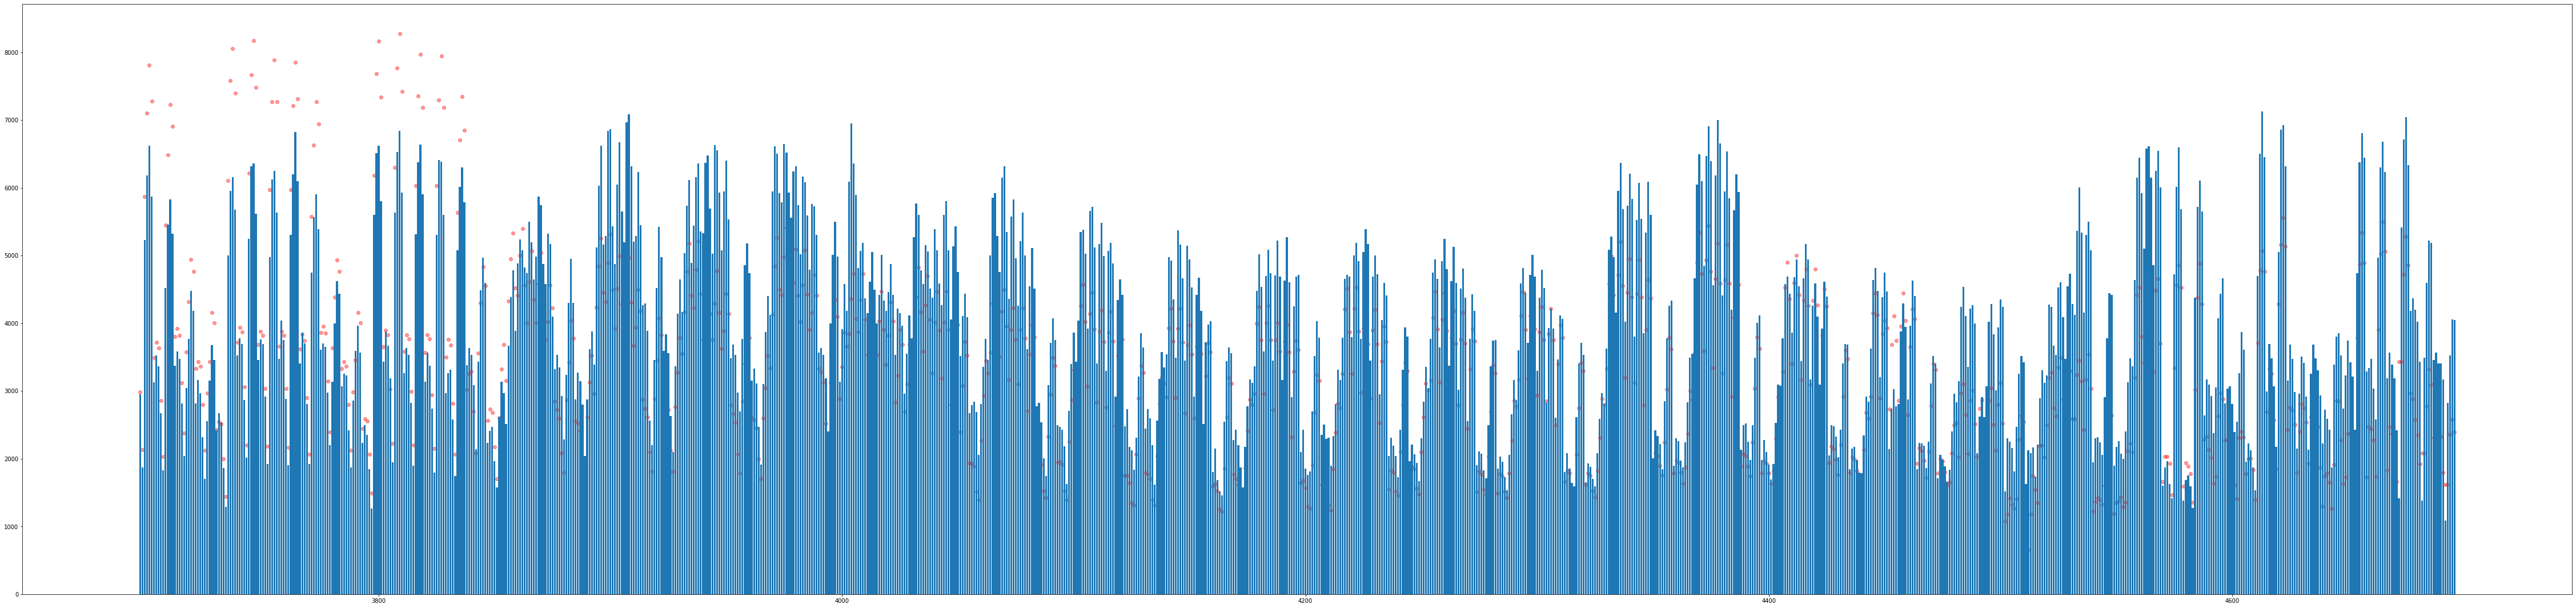

In [62]:
test, train = split_data(historical_data_chapter)
features = ['time_index', 'dayofweek','weekofyear']
param = 'cnt'
x_train = train[features].values
y_train = train[param].apply(np.log).values
x_test = test[features].values
y_test = test[param].apply(np.log).values

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=5, random_state=12, loss='ls').fit(x_train, y_train)

mse = mean_squared_error(y_test, est.predict(x_test))
print(f"mean squared error: {mse}")
rs = est.score(historical_data_chapter[features].values ,historical_data_chapter[param].apply(np.log).values)
print(f"R-square: {rs}")
preict_data = est.predict(historical_data_chapter[features].values)
fig, ax = plt.subplots(figsize=(80, 19))
sub = -1000
ax.bar(historical_data_chapter.index[sub:], historical_data_chapter.cnt.values[sub:])
ax.scatter(historical_data_chapter.index[sub:], np.exp(preict_data)[sub:], alpha=0.4, color='red')
plt.show()

mean squared error: 70.34823190596921
R-square: 0.748429368295195


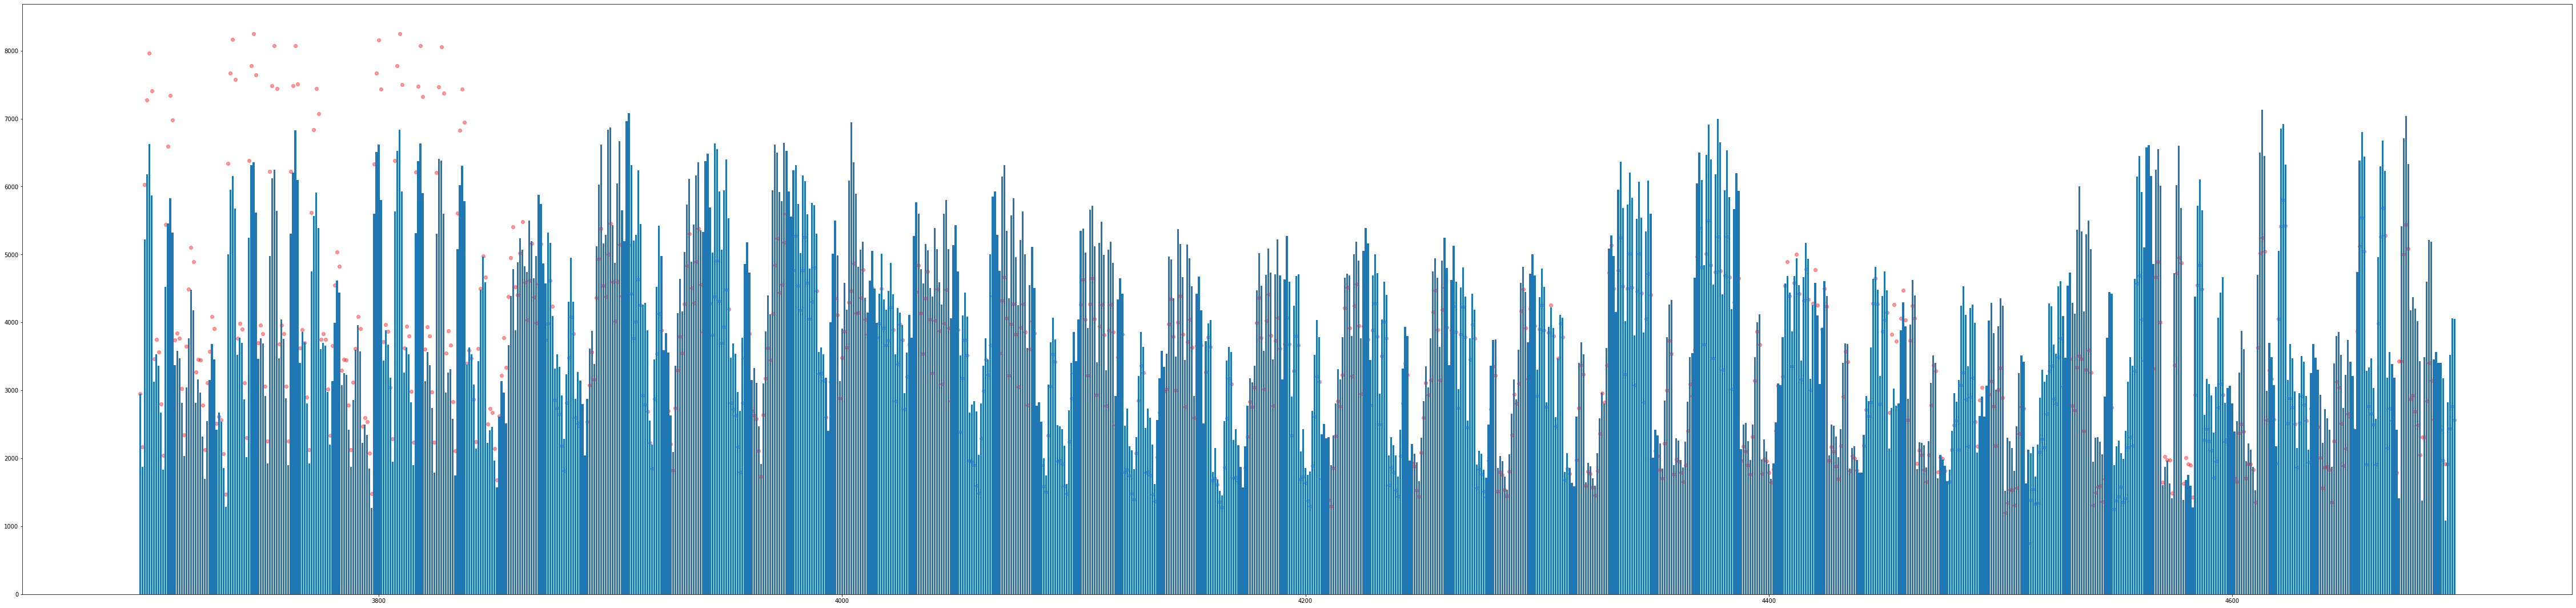

In [63]:
y_train = train[param].apply(np.sqrt).values
y_test = test[param].apply(np.sqrt).values

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=5, random_state=12, loss='ls').fit(x_train, y_train)

mse = mean_squared_error(y_test, est.predict(x_test))
print(f"mean squared error: {mse}")
rs = est.score(historical_data_chapter[features].values ,historical_data_chapter[param].apply(np.sqrt).values)
print(f"R-square: {rs}")
preict_data = est.predict(historical_data_chapter[features].values)
fig, ax = plt.subplots(figsize=(80, 19))
sub = -1000
ax.bar(historical_data_chapter.index[sub:], historical_data_chapter.cnt.values[sub:])
ax.scatter(historical_data_chapter.index[sub:], np.square(preict_data)[sub:], alpha=0.4, color='red')
plt.show()